In [53]:
using CSV
using DataFrames
using JuMP
using Gurobi
using Ipopt
using LinearAlgebra
using Random
using Plots
using SparseArrays
using XLSX
using MosekTools
using SCS
using Distributions
using HTTP
using Dates




file_loc = "/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/data/33bus"
dfg = CSV.read("$file_loc/Generator (1).csv", DataFrame)
dfl = CSV.read("$file_loc/Line (1).csv",DataFrame)
dfb = CSV.read("$file_loc/Node_full (1).csv", DataFrame)
dfpv = CSV.read("$file_loc/pvlow.csv", DataFrame)
dfbat = CSV.read("$file_loc/battery (1).csv", DataFrame)

Row,index,Node,bmax,pmax
,Int64,Int64,Int64,Int64
1,1,1,0,0
2,2,2,0,0
3,3,3,0,0
4,4,4,0,0
5,5,5,0,0
6,6,6,0,0
7,7,7,0,0
8,8,8,0,0
9,9,9,0,0


Load data

In [54]:

# Assuming you've read your dataset into a DataFrame called df
df = CSV.read("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/data/loaddata/time_series_60min_singleindex - Copy.csv", DataFrame)
# Define the normalization function
function normalize_column!(col::AbstractVector{T}) where T<:Real
    min_val = minimum(col)
    max_val = maximum(col)
    return (col) / (max_val)
end
# Apply the normalization to each numeric column
for col_name in names(df)
    if eltype(df[!, col_name]) <: Real
        df[!, col_name] = normalize_column!(df[!, col_name])
    end
end




# Define the format of your timestamps
dateformat = "yyyy-mm-dd\\THH:MM:SSZ"
# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("2015-01-02T00:00:00Z", dateformat)
end_time = DateTime("2015-01-03T00:00:00Z", dateformat)
df_24h = filter(row -> start_time <= DateTime(row[:utc_timestamp], dateformat) < end_time, df)
# Ensure that the column names are correct and that they are Symbols
# Plot the load data, using the correct column accessors
aanor = plot(df_24h.utc_timestamp, df_24h.AT_load_actual_entsoe_transparency, label="Actual Load", xlabel="Time", ylabel="Load", title="Load Data for 24 Hours", xrotation=45) # Rotates X-axis labels to make them readable
#savefig(aanor, "C:/Users/user/OneDrive - Rutgers University/Desktop/PHD- research/loadDataPlotnorm.png")





Vbase = 12.66 * 1e3;  # in Volts#basekV=12.66
Sbase = 1. * 1e6;  #in VA #baseMVA=1

cum24hourseachbus = []
for i in 1:33
    eachbus = df_24h.AT_load_actual_entsoe_transparency.* dfb[!,"Pd"][i].* 1e3.*0.5 ./ Sbase
    push!(cum24hourseachbus,eachbus)
end





# Define the format of your timestamps
dateformat = "yyyy-mm-dd\\THH:MM:SSZ"
# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("2015-01-02T00:00:00Z", dateformat)
end_time = DateTime("2015-01-03T00:00:00Z", dateformat)
df_24h = filter(row -> start_time <= DateTime(row[:utc_timestamp], dateformat) < end_time, df)
# Ensure that the column names are correct and that they are Symbols
# Plot the load data, using the correct column accessors
aanor = plot(df_24h.utc_timestamp, cum24hourseachbus[4], label="Actual Load", xlabel="Time", ylabel="Load", title="Load Data for 24 Hours", xrotation=45) # Rotates X-axis labels to make them readable
#savefig(aanor, "C:/Users/user/OneDrive - Rutgers University/Desktop/PHD- research/loadDataPlotnorm.png")




cumbuseachhour = []
for i in 1:24
    eachhour = df_24h.AT_load_actual_entsoe_transparency[i].* dfb[!,"Pd"].* 1e3.*0.5 ./ Sbase
    push!(cumbuseachhour,eachhour)
end    



cumbuseachhourreactiveload = []
for i in 1:24
    eachhourreactiveload = df_24h.AT_load_actual_entsoe_transparency[i].* dfb[!,"Qd"].* 1e3.*0.5 ./ Sbase
    push!(cumbuseachhourreactiveload,eachhourreactiveload )
end  


PV data

In [55]:
# dfpv_pu = DataFrame()
# for row in eachrow(dfpv)
#     newdfpv = (index=row.index, Node = row.Node , S = row.S .* 1e3 ./ Sbase )
#     push!(dfpv_pu, newdfpv)
# end



# # Define the format of your timestamps
# dateformat = "yyyy-mm-dd\\THH:MM:SSZ"
# # Filter the DataFrame to include only the rows for the 24-hour period
# start_time = DateTime("2015-01-02T00:00:00Z", dateformat)
# end_time = DateTime("2015-01-03T00:00:00Z", dateformat)
# df_24h = filter(row -> start_time <= DateTime(row[:utc_timestamp], dateformat) < end_time, df)
# # Ensure that the column names are correct and that they are Symbols
# # Plot the load data, using the correct column accessors
# bbnor = plot(df_24h.utc_timestamp, df_24h.AT_solar_generation_actual, label="Generated Power", xlabel="Time", ylabel="Generated Power (MW)", title="Generated Power for 24 Hours", xrotation=45) # Rotates X-axis labels to make them readable
# #savefig(bbnor, "C:/Users/user/OneDrive - Rutgers University/Desktop/PHD- research/generationDataPlotnor.png")



# Vbase = 12.66 * 1e3;  # in Volts#basekV=12.66
# Sbase = 1. * 1e6;  #in VA #baseMVA=1
# cum24hourseachbuspv = []
# for i in 1:33
#     eachbuspv =  df_24h.AT_solar_generation_actual.* dfpv[!, :S][i]# here we multiply each curve (24 hours) by a single value corres
#     push!(cum24hourseachbuspv,eachbuspv)
# end




# cumbuseachhourpv = []
# for i in 1:24
#     eachhourpv = df_24h.AT_solar_generation_actual[i].* dfpv[!, :S] # here we scale the system capacity for all 33 buses at one specific hour by multiplying the sysytem capacity for all 33 buse by the amount of genereated pv (curve) at one specific time. then we repeat ut 24 hours for all hours. so we have 24 33dimension vectors.
#     push!(cumbuseachhourpv,eachhourpv)
# end    
# cumbuseachhourpv[10][:]




# pvcum = []
# for h in 1:24
#     Random.seed!(123)
#     pav = rand(length(cumbuseachhourpv[h][:])) .* cumbuseachhourpv[h][:] # Generate random scaling factors between 0 and 1 and then Scale the values between 0 and 100% of system capacity in each hour , it means that we have generated pv a 33 colum vector data for each hour in 24 hours
#     pavs = pav .* 1e3 ./ Sbase 
#     push!(pvcum,pavs)
# end  
# pvcum

In [56]:



data_url = "https://raw.githubusercontent.com/mieth-robert/testdata/main/single_household_smart_home.csv"
response = HTTP.get(data_url)
smart_home_data = CSV.File(IOBuffer(response.body)) |> DataFrame



smart_home_data[!, :local_15min] = DateTime.(smart_home_data[!, :local_15min], "m/d/y H:M")
# Load your smart_home_data DataFrame here
# smart_home_data = ...

# Define the format of your timestamps
dateformat = "m/d/y H:M"

# Ensure 'local_15min' is parsed to DateTime format if it's not already
#smart_home_data[!, :local_15min] = DateTime.(smart_home_data[!, :local_15min], dateformat)

# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("3/2/15 0:0", dateformat)
end_time = DateTime("3/3/15 0:0", dateformat)
df_24h = filter(row -> start_time <= row[:local_15min] < end_time, smart_home_data)

# Further filter to get only the start of each hour
df_hourly = df_24h[minute.(df_24h[!, :local_15min]) .== 0, :]

# Plot the solar data
plt = plot(df_hourly.local_15min, df_hourly.solar, label="Solar Energy", xlabel="Time", ylabel="Energy", title="Solar Energy Data for March 3, 2015", xrotation=45)






function normalize_column!(col::AbstractVector{T}) where T<:Real
    min_val = minimum(col)
    max_val = maximum(col)
    return (col) / (max_val)
end
# Apply the normalization to each numeric column
for col_name in names( df_hourly)
    if eltype( df_hourly[!, col_name]) <: Real
         df_hourly[!, col_name] = normalize_column!( df_hourly[!, col_name])
    end
end








# Define the format of your timestamps if your 'local_15min' column is in string format that needs parsing
dateformat = "m/d/y H:M"

# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("3/2/15 0:0", dateformat)
end_time = DateTime("3/3/15 0:0", dateformat)
df_24h = filter(row -> start_time <= row[:local_15min] < end_time, df_hourly)
# Ensure that the column names are correct and that they are Symbols
# Plot the solar data
aanor = plot(df_24h.local_15min, df_24h.solar, label="Solar Energy", xlabel="Time", ylabel="Energy", title="Solar Energy Data for March 3, 2015", xrotation=45)











Vbase = 12.66 * 1e3;  # in Volts#basekV=12.66
Sbase = 1. * 1e6;  #in VA #baseMVA=1
df_24h.solar[21] = 0.0005
cum24hourseachbuspv = []
for i in 1:33
    eachbuspv = df_24h.solar.* dfpv[!, :S][i].*2# here we multiply each curve (24 hours) by a single value corres
    push!(cum24hourseachbuspv,eachbuspv)
end




cumbuseachhourpv = []
for i in 1:24
    eachhourpv = df_24h.solar[i].* dfpv[!, :S].*2 # here we scale the system capacity for all 33 buses at one specific hour by multiplying the sysytem capacity for all 33 buse by the amount of genereated pv (curve) at one specific time. then we repeat ut 24 hours for all hours. so we have 24 33dimension vectors.
    push!(cumbuseachhourpv,eachhourpv)
end    
cumbuseachhourpv[10][:]




# pvcum = []
# for h in 1:24
#     Random.seed!(123)
#     pav = rand(length(cumbuseachhourpv[h][:])) .* cumbuseachhourpv[h][:] # Generate random scaling factors between 0 and 1 and then Scale the values between 0 and 100% of system capacity in each hour , it means that we have generated pv a 33 colum vector data for each hour in 24 hours
#     pavs = pav .* 1e3 ./ Sbase 
#     push!(pvcum,pavs)
# end  
# pvcum


cumbuseachhourpv = cumbuseachhourpv.* 1e3 ./ Sbase



24-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.000339943342776204, 0.0, 0.0, 0.0, 0.000169971671388102, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.000339943342776204, 0.0, 0.0, 0.0, 0.000169971671388102, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.000339943342776204, 0.0, 0.0, 0.0, 0.000169971671388102, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.000339943342776204, 0.0, 0.0, 0.0, 0.000169971671388102, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.000339943342776204, 0.0, 0.0, 0.0, 0.000169971671388102, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.000339943342776204, 0.0, 0.0, 0.0, 0.000169971671388102, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0

In [57]:
# S_per_time_pu=cumbuseachhourpv.* 1e3 ./ Sbase

In [58]:
using Printf

# Function to adjust and format numbers, keeping them as numbers
function adjust_and_format_number(num)
    if abs(num) < 1e-4
        return 0.0
    else
        return round(num, digits=4)
    end
end

# Apply the function to each number in the vector pvcum
cumbuseachhourpv = map(sublist -> map(adjust_and_format_number, sublist), cumbuseachhourpv)

# Displaying a sample from the result
println(cumbuseachhourpv[10])

# Apply the same process for other vectors
cumbuseachhour = map(sublist -> map(adjust_and_format_number, sublist), cumbuseachhour)
println(cumbuseachhour[10])

cumbuseachhourreactiveload = map(sublist -> map(adjust_and_format_number, sublist), cumbuseachhourreactiveload)
println(cumbuseachhourreactiveload[10])


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0334, 0.0134, 0.0334, 0.0134, 0.0, 0.0, 0.0334, 0.0134, 0.0, 0.0201, 0.0, 0.0401, 0.0, 0.0, 0.0, 0.0201, 0.0, 0.0]
[0.0, 0.0486, 0.0438, 0.0583, 0.0292, 0.0292, 0.0972, 0.0972, 0.0292, 0.0292, 0.0219, 0.0292, 0.0292, 0.0583, 0.0292, 0.0292, 0.0292, 0.0438, 0.0438, 0.0438, 0.0438, 0.0438, 0.0438, 0.2042, 0.2042, 0.0292, 0.0292, 0.0292, 0.0583, 0.0972, 0.0729, 0.1021, 0.0292]
[0.0, 0.0292, 0.0194, 0.0389, 0.0146, 0.0097, 0.0486, 0.0486, 0.0097, 0.0097, 0.0146, 0.017, 0.017, 0.0389, 0.0049, 0.0097, 0.0097, 0.0194, 0.0194, 0.0194, 0.0194, 0.0194, 0.0243, 0.0972, 0.0972, 0.0122, 0.0122, 0.0097, 0.034, 0.2917, 0.034, 0.0486, 0.0194]


In [59]:
# define location of files

htime= 14

#define voltage base and Sbase 
Vbase = 12.66 * 1e3;  # in Volts#basekV=12.66
Sbase = 1. * 1e6;  #in VA #baseMVA=1

#convert impedances from Ohms to p.u. - loads from kW to pu - battery data from kw to pu - pv data from kw to pu
dfb_pu = DataFrame()
for row in eachrow(dfb)
    newdfb = (index=row.index, Node = row.Node, Pd=row.Pd .* 1e3.*0.5 ./ Sbase, Qd=row.Qd.*0.5 .* 1e3 ./ Sbase, Vmax=1.1, Vmin=0.9, r=row.r ./(Vbase^2 / Sbase), x=row.x ./(Vbase^2 / Sbase), b= row.b)
    push!(dfb_pu, newdfb)
end

dfl_pu = DataFrame()
for row in eachrow(dfl)
    newdfl = (index=row.index, to = row.to , from=row.from , r=row.r ./  (Vbase^2 / Sbase), x=row.x ./ (Vbase^2 / Sbase), b=row.b, s=row.s, g = row.g)
    push!(dfl_pu, newdfl)
end

dfbat_pu = DataFrame()
for row in eachrow(dfbat)
    newdfbat = (index=row.index, Node = row.Node , bmax=row.bmax .* 1e3 ./ Sbase , pmax=row.pmax .* 1e3 ./ Sbase )
    push!(dfbat_pu, newdfbat)
end

dfpv_pu = DataFrame()
for row in eachrow(dfpv)
    newdfpv = (index=row.index, Node = row.Node , S = row.S .* 1e3.*2 ./ Sbase )
    push!(dfpv_pu, newdfpv)
end


# bring the data in a more useable form
println(">>> preparing data")
buses = []
for row in eachrow(dfb_pu)
    newbus = (index=row.index, ancestor=[], children=[], pd=row.Pd, qd=row.Qd, Vmax=row.Vmax, Vmin = row.Vmin)
    push!(buses, newbus)
end

lines = []
for row in eachrow(dfl_pu)
    newline = (index=row.index, r=row.r, x=row.x, from=row.to, to=row.from)
    push!(buses[newline.to].ancestor, newline.from)
    push!(buses[newline.from].children, newline.to)
    push!(lines, newline)
end

PVs = []
for row in eachrow(dfpv_pu)
    newPV = (index=row.index, S=row.S)
    push!(PVs, newPV)
end

energy_storage_systems = []
for row in eachrow(dfbat_pu)
    newenergy_storage_system = (index=row.index, Pbmax=row.pmax,Bmax = row.bmax )
    push!(energy_storage_systems, newenergy_storage_system)
end

nbuses = length(buses)
nlines = length(lines)
nPVs = length(PVs)
nenergy_storage_systems = length(energy_storage_systems)

# now compute the same thing in the matrix form
println(">>> compute matrizes")
# define A matrix (with substation bus!)
A = zeros(length(lines), length(buses))
for bus in buses
    a = bus.index
    while a != 1
        A[a-1, bus.index] = 1
        a = buses[a].ancestor[1]
    end
end

# define load active and reactive power vectors
pl= cumbuseachhour[htime]
ql = cumbuseachhourreactiveload[htime]
pav_pu = cumbuseachhourpv[htime]




# Random.seed!(123)
# random_factors = 1 .* rand(length(dfpv[!, :S])) 
# pav = random_factors .* dfpv[!, :S]
# pav_pu=pav .* 1e3 ./ Sbase 
######################################



# define power generation vectors
#Random.seed!(123)
#pav = rand(length(dfpv_pu[!, :S])) .* dfpv_pu[!, :S] # Generate random scaling factors between 0 and 1 and then Scale the values between 0 and 100%

#pavs = pav .* 5

# set substation voltage
u_0 = 1

# define remaining matrizes
diag_r = Diagonal([line.r for line in lines])
diag_x = Diagonal([line.x for line in lines])
R = 2*A'*diag_r*A
B = 2*A'*diag_x*A
a = ones(nbuses) .* u_0 


# define parameters relatedd to the price
c = fill(10, nbuses) #the price associated with the power consumed by the customers
d= fill(3, nbuses) # the feed-in tariff cost to the utility
e= fill(30, nbuses) # the cost of reactive power injection/absorption from the inverters
f= fill(6,nbuses) # the cost of active power curtailment

>>> preparing data
>>> compute matrizes


33-element Vector{Int64}:
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 ⋮
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6

In [60]:
forecast_values = hcat(pav_pu,pl,ql)

33×3 Matrix{Float64}:
 0.0  0.0     0.0
 0.0  0.0458  0.0275
 0.0  0.0412  0.0183
 0.0  0.0549  0.0366
 0.0  0.0275  0.0137
 0.0  0.0275  0.0092
 0.0  0.0916  0.0458
 0.0  0.0916  0.0458
 0.0  0.0275  0.0092
 0.0  0.0275  0.0092
 0.0  0.0206  0.0137
 0.0  0.0275  0.016
 0.0  0.0275  0.016
 ⋮            
 0.5  0.0412  0.0183
 0.2  0.0412  0.0229
 0.0  0.1923  0.0916
 0.3  0.1923  0.0916
 0.0  0.0275  0.0114
 0.6  0.0275  0.0114
 0.0  0.0275  0.0092
 0.0  0.0549  0.032
 0.0  0.0916  0.2747
 0.3  0.0687  0.032
 0.0  0.0961  0.0458
 0.0  0.0275  0.0183

In [61]:
# Function to create clusters
function create_clusters(n_buses, n_clusters)
    Random.seed!(123)
    buses = collect(1:n_buses) # Create a list of buses
    clusters = [Int[] for _ in 1:n_clusters] # Initialize clusters

    while length(buses) > 0
        for cluster in clusters
            if length(buses) == 0
                break
            end
            # Randomly choose a bus to be in this cluster
            bus_index = rand(1:length(buses))
            bus = buses[bus_index]

            # Add the bus to the current cluster
            push!(cluster, bus)

            # Remove the bus from the list of buses
            deleteat!(buses, bus_index)

            # Sort the cluster to ensure buses are close together
            sort!(cluster)
        end
    end
    return clusters
end

# Define the number of buses and clusters
n_buses = 33
n_clusters = 5

5

In [62]:
clusters= [[1,2,3,4,5,6,7,8,9,10],[11,12,13,14,15,16,17,18],[19,20,21,22],[23,24,25],[26,27,28,29,30,31,32,33]]


# clusters= [[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11],[12],[13],[14],[15],[16],[17],[18],[19],[20],[21],[22],[23],[24],[25],[26],[27],[28],[29],[30],[31],[32],[33]]

5-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 [11, 12, 13, 14, 15, 16, 17, 18]
 [19, 20, 21, 22]
 [23, 24, 25]
 [26, 27, 28, 29, 30, 31, 32, 33]

In [63]:
F=pl./ql
F[1]=0

0

In [64]:
Random.seed!(123)
# Function to create samples for vector deltas
function create_delta_samples(clusters, forecast_values, n_samples)
    deltas_samples = []

    # For each cluster, create samples for delta vector
    for cluster in clusters
        cluster_size = length(cluster)
        delta_size = 3 * cluster_size
        samples = zeros(delta_size, n_samples)

        # Create samples
        for i in 1:n_samples
            for j in 1:cluster_size
                # p_av follows a normal distribution with mean 0 and std deviation of 10% of forecast
                p_av_forecast = forecast_values[cluster[j], 1]
                p_av_std = 0.2 * p_av_forecast
                p_av_dist = Normal(0, p_av_std)
                p_av_sample = rand(p_av_dist)
                p_av_sample = min.(p_av_sample, dfpv_pu[cluster[j], :S] - pav_pu[cluster[j]])
                p_av_sample = max.(p_av_sample, - pav_pu[cluster[j]])

                # p_l is uniformly sampled between 0.5 and 1 of forecast
                # q_l is uniformly sampled between 0.9 and 1.1 of forecast
                p_l_forecast = forecast_values[cluster[j], 2]
                p_l_std = 0.2 * p_l_forecast
                p_l_dist = Normal(0, p_l_std)
                p_l_sample = rand(p_l_dist)
                p_l_sample = min.(p_l_sample, 1.2 * p_l_forecast - p_l_forecast)
                p_l_sample = max.(p_l_sample, 0.5 * p_l_forecast- p_l_forecast)
                
                if F[cluster[j]] == 0
                    q_l_sample= 0
                else    
                    q_l_sample = (p_l_sample + p_l_forecast) ./ F[cluster[j]]
                end
                
                # Add samples to the corresponding positions in the delta vector
                samples[(j-1)*3+1, i] = p_av_sample + p_av_forecast
                samples[(j-1)*3+2, i] = p_l_sample + p_l_forecast
                samples[(j-1)*3+3, i] = q_l_sample
            end
        end

        # Add the samples for this cluster's delta to the list
        push!(deltas_samples, samples)
    end
    return deltas_samples
end















# Function to create samples for vector deltas
# function create_delta_samples(clusters, forecast_values, n_samples)
#     deltas_samples = []

#     # For each cluster, create samples for delta vector
#     for cluster in clusters
#         cluster_size = length(cluster)
#         delta_size = 3 * cluster_size
#         samples = zeros(delta_size, n_samples)

#         # Create samples
#         for i in 1:n_samples
#             for j in 1:cluster_size
#                 # p_av follows a normal distribution with mean 0 and std deviation of 10% of forecast
#                 p_av_forecast = forecast_values[cluster[j], 1]
#                 p_av_std = 0.1 * p_av_forecast
#                 p_av_dist = Normal(0, p_av_std)
#                 p_av_sample = rand(p_av_dist)
#                 p_av_sample = min.(p_av_sample, dfpv_pu[!,:S][cluster[j]] - pav_pu[cluster[j]])
#                 p_av_sample = max.(p_av_sample, - pav_pu[cluster[j]])

#                 # p_l is uniformly sampled between 0.5 and 1 of forecast
#                 # q_l is uniformly sampled between 0.9 and 1.1 of forecast
#                 p_l_forecast = forecast_values[cluster[j], 2]
#                 if p_l_forecast > 0
#                     p_l_sample = rand(Uniform(0.5 * p_l_forecast, p_l_forecast))
#                 else
#                     p_l_sample = 0 
#                 end
#                 q_l_forecast = forecast_values[cluster[j], 3]
#                 if q_l_forecast > 0
#                     q_l_sample = rand(Uniform(0.9 * q_l_forecast, 1.1 * q_l_forecast))
#                 else
#                     q_l_sample = 0 
#                 end

#                 # Add samples to the corresponding positions in the delta vector
#                 samples[(j-1)*3+1, i] = p_av_sample+pav_pu[cluster[j]]
#                 samples[(j-1)*3+2, i] = p_l_sample
#                 samples[(j-1)*3+3, i] = q_l_sample
#             end
#         end

#         # Add the samples for this cluster's delta to the list
#         push!(deltas_samples, samples)
#     end
#     return deltas_samples
# end



# Create the samples for vector deltas
n_samples = 5 # Number of samples for each vector delta
deltas_samples = create_delta_samples(clusters, forecast_values, n_samples)

5-element Vector{Any}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.024539361357983222 0.01805583946441207 … 0.033 0.023828062006659993; 0.008209531799761659 0.006040499020821492 … 0.01104 0.007971569834955342]
 [0.0 0.0 … 0.0 0.0; 0.021005709012194604 0.020653645804837854 … 0.0242770899402646 0.021713820419996012; … ; 0.04124673117387729 0.03395536191933392 … 0.04375661932861366 0.03416488500597577; 0.018320756807814427 0.015082114638927445 … 0.0194355857697483 0.01517517950508147]
 [0.2 0.18942783844567643 … 0.18186653905715572 0.2; 0.02907289116074704 0.04155941697121944 … 0.04201081411972257 0.049236959909216206; … ; 0.04455754515895903 0.03749986604494199 … 0.03742393338681268 0.04536061554717319; 0.019791336806042482 0.016656493898602874 … 0.016622766528608546 0.02014804040080751]
 [0.2 0.2 … 0.19403308247033474 0.19984011449694922; 0.04944 0.029457385827324878 … 0.0493749739218739 0.04246755375280615; … ; 0.18376334741275485 0.14824358814852462 … 0.15223853502281104 0.156718139

In [65]:
clusters

5-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 [11, 12, 13, 14, 15, 16, 17, 18]
 [19, 20, 21, 22]
 [23, 24, 25]
 [26, 27, 28, 29, 30, 31, 32, 33]

In [66]:
function create_delta_max(clusters, dfpv_pu,pl,ql)
    deltas_max = []
    for cluster in clusters
        cluster_size = length(cluster)
        delta_size = 3 * cluster_size
        max = zeros(delta_size, 1)
        for i in 1:1
            for j in 1:cluster_size
                p_av_max =  dfpv_pu[cluster[j], :S]
                p_l_max=  1.2*pl[cluster[j]]
                if F[cluster[j]]==0
                    q_l_max = 0
                else    
                    q_l_max = 1.2*pl[cluster[j]]/F[cluster[j]]
                end    
                # Add maxvalues to the corresponding positions in the delta_max vector
                max[(j-1)*3+1, i] = p_av_max
                max[(j-1)*3+2, i] = p_l_max
                max[(j-1)*3+3, i] = q_l_max
            end
        end
        push!(deltas_max, max)
    end
    return deltas_max
end
deltas_max = create_delta_max(clusters, dfpv_pu,pl,ql)








# function create_delta_max(clusters, PVs,pl,ql)
#     deltas_max = []
#     for cluster in clusters
#         cluster_size = length(cluster)
#         delta_size = 3 * cluster_size
#         max = zeros(delta_size, 1)
#         for i in 1:1
#             for j in 1:cluster_size
#                 p_av_max = PVs[cluster[j]].S
#                 p_l_max=  1*pl[cluster[j]]
#                 q_l_max = 1.1*ql[cluster[j]]
#                 # Add maxvalues to the corresponding positions in the delta_max vector
#                 max[(j-1)*3+1, i] = p_av_max
#                 max[(j-1)*3+2, i] = p_l_max
#                 max[(j-1)*3+3, i] = q_l_max
#             end
#         end
#         push!(deltas_max, max)
#     end
#     return deltas_max
# end
# deltas_max = create_delta_max(clusters, PVs,pl,ql)

5-element Vector{Any}:
 [0.0; 0.0; … ; 0.033; 0.01104;;]
 [0.0; 0.02472; … ; 0.04944; 0.02196;;]
 [0.2; 0.04944; … ; 0.04944; 0.02196;;]
 [0.2; 0.04944; … ; 0.23076; 0.10992;;]
 [0.0; 0.033; … ; 0.033; 0.021960000000000004;;]

In [67]:


function create_delta_min(clusters, dfpv_pu,pl,ql)
    deltas_min = []
    for cluster in clusters
        cluster_size = length(cluster)
        delta_size = 3 * cluster_size
        min = zeros(delta_size, 1)
        for i in 1:1
            for j in 1:cluster_size
                p_av_min = 0
                p_l_min=  0.5*pl[cluster[j]]
                if F[cluster[j]]==0
                    q_l_min = 0
                else    
                    q_l_min = 0.5*pl[cluster[j]]/F[cluster[j]]
                end 
                # Add minvalues to the corresponding positions in the delta_min vector
                min[(j-1)*3+1, i] = p_av_min
                min[(j-1)*3+2, i] = p_l_min
                min[(j-1)*3+3, i] = q_l_min
            end
        end
        push!(deltas_min, min)
    end
    return deltas_min
end
deltas_min = create_delta_min(clusters, dfpv_pu,pl,ql)





# function create_delta_min(clusters, PVs,pl,ql)
#     deltas_min = []
#     for cluster in clusters
#         cluster_size = length(cluster)
#         delta_size = 3 * cluster_size
#         min = zeros(delta_size, 1)
#         for i in 1:1
#             for j in 1:cluster_size
#                 p_av_min = 0
#                 p_l_min=  0.5*pl[cluster[j]]
#                 q_l_min = 0.9*ql[cluster[j]]
#                 # Add minvalues to the corresponding positions in the delta_min vector
#                 min[(j-1)*3+1, i] = p_av_min
#                 min[(j-1)*3+2, i] = p_l_min
#                 min[(j-1)*3+3, i] = q_l_min
#             end
#         end
#         push!(deltas_min, min)
#     end
#     return deltas_min
# end
# deltas_min = create_delta_min(clusters, PVs,pl,ql)

5-element Vector{Any}:
 [0.0; 0.0; … ; 0.01375; 0.0046;;]
 [0.0; 0.0103; … ; 0.0206; 0.00915;;]
 [0.0; 0.0206; … ; 0.0206; 0.00915;;]
 [0.0; 0.0206; … ; 0.09615; 0.0458;;]
 [0.0; 0.01375; … ; 0.01375; 0.00915;;]

In [68]:
deltas_hat = deltas_samples

5-element Vector{Any}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.024539361357983222 0.01805583946441207 … 0.033 0.023828062006659993; 0.008209531799761659 0.006040499020821492 … 0.01104 0.007971569834955342]
 [0.0 0.0 … 0.0 0.0; 0.021005709012194604 0.020653645804837854 … 0.0242770899402646 0.021713820419996012; … ; 0.04124673117387729 0.03395536191933392 … 0.04375661932861366 0.03416488500597577; 0.018320756807814427 0.015082114638927445 … 0.0194355857697483 0.01517517950508147]
 [0.2 0.18942783844567643 … 0.18186653905715572 0.2; 0.02907289116074704 0.04155941697121944 … 0.04201081411972257 0.049236959909216206; … ; 0.04455754515895903 0.03749986604494199 … 0.03742393338681268 0.04536061554717319; 0.019791336806042482 0.016656493898602874 … 0.016622766528608546 0.02014804040080751]
 [0.2 0.2 … 0.19403308247033474 0.19984011449694922; 0.04944 0.029457385827324878 … 0.0493749739218739 0.04246755375280615; … ; 0.18376334741275485 0.14824358814852462 … 0.15223853502281104 0.156718139

In [69]:
length(deltas_hat)

5

In [70]:
generalobj1 = []
    # For each cluster, create samples for delta vector
    for cluster in clusters
        cluster_size = length(cluster)
        delta_size = 3 * cluster_size
        general = zeros(1,delta_size)
# Create samples
        for i in 1:1
            for j in 1:cluster_size
                p_av_min = 0
                p_l_min=  0
                q_l_min = 0

                # Add samples to the corresponding positions in the delta vector
                general[1,(j-1)*3+1] = p_av_min
                general[1,(j-1)*3+2] = p_l_min
                general[1,(j-1)*3+3] = q_l_min
            end
        end
        # Add the samples for this cluster's delta to the list
        push!(generalobj1, general)
    end

In [71]:
pvuncer_loc= [16, 17,18,19,22,23,25,27,31] 
# pvuncer_loc= [8,11,12,16, 17,18,19,22,23,25,27,29,31] 
# pvuncer_loc= [3,5,6,8,11,12,14,16, 17,18,19,21,22,23,25,27,29,31,33] 
# pvuncer_loc= [4,6,8,11,12,16, 17,18,19,22,23,25,27,29,31,33] 

9-element Vector{Int64}:
 16
 17
 18
 19
 22
 23
 25
 27
 31

In [72]:
clusters

5-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 [11, 12, 13, 14, 15, 16, 17, 18]
 [19, 20, 21, 22]
 [23, 24, 25]
 [26, 27, 28, 29, 30, 31, 32, 33]

In [73]:
#function run_optimization(epsilon)
    function run_optimization(epsilon)
    n_clusters = 5
    ϵ = zeros(Float64, n_clusters)
    for i in 1:n_clusters
        ϵ[i] = epsilon
    end 
    
#      ϵ = [0.01,0.01,0.01,0.01,0.01]
#      ϵ[2]=epsilon
    
    model = Model(SCS.Optimizer)
##############################################################
    n_clusters = 5
    N =nbuses
    D = n_clusters
    o= n_clusters
    Nprime = n_samples
    Vmax=1.1
    Vmin=0.9
    eta1 =0.05
    eta=0.05
    er=[]
    for j in 1:n_clusters
        er1= length(clusters[j])
        push!(er,er1)
    end    
    maximum(er)# the number of buses in the cluster which has the maximum buses
############################################################
    @variable(model,0 <= alpha[n=1:nbuses] <= 1) #variable for fraction of active power curtailed by RES
    @variable(model, qc[n=1:nPVs] ) #variable for reactive power provided by RES
    @variable(model, 0 <= pb[n=1: nenergy_storage_systems]) #variable for rate of (dis)charge for energy storage 
    # @variable(model, bb[n=1: nenergy_storage_systems]>= 0) #variable for state of charge of energy storage
    @variable(model, y1[n=1:nPVs] >=0)
    @variable(model, y2[n=1:nPVs] >=0)
    
    
    #auxillary variables for wc exp. cost reformulation
    @variable(model, λ_co[f=1:D] >=0)
    @variable(model, s_co1[n=1:N, i = 1:Nprime] >=0)
    @variable(model, s_co2[n=1:N, i = 1:Nprime] >=0)
    #@variable(model, S_cost[f=1:D, i=1:Nprime])
#     @variable(model, q[f=1:D, i=1:Nprime])
#     @variable(model, U[f=1:D, m=1:3*length(clusters[f]), i=1:Nprime] >=0)
#     @variable(model, L[f=1:D, m=1:3*length(clusters[f]), i=1:Nprime] >=0)
    # auxillary variables for CVaR reformulation
    @variable(model, varphi <=0)
    @variable(model, gamma[n=1:N] <=0)
    
    #DEFINE MATRISES
####################################################################    
        A = []
        for cluster in clusters
            cluster_size = length(cluster)
            delta_size = 3 * cluster_size
            aa = Array{AffExpr}(undef, nbuses, delta_size)
            for n in 1:nbuses
                for j in 1:cluster_size 
                    first =  R[n,cluster[j]]*(1-alpha[cluster[j]])
                    second=  -R[n,cluster[j]]
                    third = -B[n,cluster[j]]
                    # Add elements to the corresponding positions in the matrix A
                    aa[n,(j-1)*3+1] = first
                    aa[n,(j-1)*3+2] = second
                    aa[n,(j-1)*3+3] = third
                end
            end
            push!(A, aa)
        end
######################################################################
        AJ=vcat(A,-A,generalobj1)
         #a_prime= zeros(2*nbuses+1,n_clusters,3*maximum(er))
        a_prime = Array{AffExpr}(undef, 2*nbuses+1, n_clusters, 3*maximum(er))
        for i in 1:(2*nbuses+1)
            for j in 1:n_clusters
                for k in 1:3*maximum(er)
                    a_prime[i, j, k] = @expression(model, 0)
                end
            end
        end
        #a_prime = Array{AffExpr}(undef, 2*nbuses+1, n_clusters, 3*maximum(er))
        for b in 1:length(AJ)
            for c in 1:n_buses
                if b < n_clusters+1
                    if 3*length(clusters[b]) == 3*maximum(er)
                        for d in 1:3*maximum(er)
                            a_prime[c,b,d] = AJ[b][c,:][d]
                        end   
                    else
                        for d in 1:3*maximum(er)
                            if d < 3*length(clusters[b])+1
                                a_prime[c,b,d] = AJ[b][c,:][d]
                            else
                                a_prime[c,b,d]=0
                            end    
                        end    
                    end
                elseif b > n_clusters && b < 2*n_clusters+1 
                    if 3*length(clusters[b - n_clusters]) == 3*maximum(er)
                         for d in 1:3*maximum(er)
                             a_prime[c + nbuses,b - n_clusters,d] = AJ[b][c,:][d]
                         end   
                    else
                        for d in 1:3*maximum(er)
                            if d < 3*length(clusters[b - n_clusters])+1
                                a_prime[c + nbuses,b - n_clusters,d] = AJ[b][c,:][d]
                            else
                                 a_prime[c + nbuses,b - n_clusters,d]=0
                            end    
                         end  
                    end    
                else
                    if c == 1
                        if 3*length(clusters[b - 2*n_clusters]) == 3*maximum(er)
                            for d in 1:3*maximum(er) 
                                a_prime[c + 2*nbuses,b - 2*n_clusters,d] = AJ[b][c,:][d]
                            end    
                        else
                             for d in 1:3*maximum(er)
                                if d < 3*length(clusters[b - 2*n_clusters])+1
                                     a_prime[c + 2*nbuses,b - 2*n_clusters,d] =  AJ[b - 2*n_clusters][c,:][d]
                                else
                                    a_prime[c + 2*nbuses,b - 2*n_clusters,d]=0
                                end    
                             end           
                         end
                    end
                 end
             end
        end    

    ######################################################################
    # THIS MATRIX IS CREATED FOR USING IN MATRIX M   
        generalobj2 = []
        for cluster in clusters
            cluster_size = length(cluster)
            delta_size = 3 * cluster_size
            general2 = Array{AffExpr}(undef, 1, delta_size)
            for i in 1:1
                for j in 1:cluster_size
                    # p_av follows a normal distribution with mean 0 and std deviation of 10% of forecast
                    p_av_min = -c[cluster[j]]* (1-alpha[cluster[j]])+f[cluster[j]]*alpha[cluster[j]]
                    p_l_min=  c[cluster[j]] 
                    q_l_min = 0

                    general2[1,(j-1)*3+1] = p_av_min
                    general2[1,(j-1)*3+2] = p_l_min
                    general2[1,(j-1)*3+3] = q_l_min
                end
            end
            push!(generalobj2, general2)
        end
#######################################################################
    # matrix M
    # Initialize the matrix of vectors
    M = Array{Array{AffExpr, 1}}(undef, n_clusters, n_clusters)
    for i in 1:n_clusters
        for j in 1:n_clusters
            if i == j
                # If deltas_min[i] is already a vector, transpose and then convert to vector
                M[i, j] = vec(generalobj2[i])
            else
                M[i, j] = vec(zeros(1, 3 * length(clusters[j])))
            end
        end
    end
#################################################################


#########################################################
    @expression(model, b_first[t=1:nbuses], -R[t,:]'*pb +B[t,:]'*qc +a[t] - Vmax -varphi)
    @expression(model, b_second[t=1:nbuses], R[t,:]'*pb - B[t,:]'*qc -a[t] + Vmin -varphi)
    @expression(model, b_third_1[t=1:nbuses], qc[t]^2 - dfpv_pu[t, :S]^2 - gamma[t])
    b_third_0= zeros(Float64, nbuses)
#*    @expression(model, v[n=1:nbuses],  A_filtered[n,:]'*sigma_hat_filtered_second_samples -R[n,:]'*pb +B[n,:]'*qc +a[n])# the definition of voltage in our model
    @expression(model, voltage[n=1:nbuses], sum(dot(A[f][n,:], deltas_samples[f][:,1]) for f in 1:D) -R[n,:]'*pb +B[n,:]'*qc +a[n])# the definition of voltage in our model
    @expression(model, c_prime[i=1:2*nbuses+1], 
    if i <= nbuses
        b_first[i]  # The first 33 elements from b_first
    elseif i <= 2 * nbuses
        b_second[i - nbuses]  # The next 33 elements from b_second
    else
        0  # The 67th element is zero
    end
)
    @variable(model, varpi) 
    @variable(model, psi[n=1:N]) 
    ########################
    @variable(model, λ_cc[f=1:D] >=0) #related to constraint v[t] >= buses[t].Vmin and  v[t] =< buses[t].Vmax
    @variable(model, λ_third_cc[n=1:N ] >=0) # related to constraint ((1-alpha[PV.index])*pavs[PV.index])^2 + (qc[PV.index])^2 <= (PV.S)^2
    ##################
    @variable(model, P_cc[i=1:Nprime]>=0 )
    @variable(model, P[k=1:2*nbuses+1,f=1:D, i=1:Nprime] >=0)
    @variable(model, z[ k=1:2*nbuses+1,f=1:D, i=1:Nprime])
    @variable(model, u[ k=1:2*nbuses+1, f=1:D, m=1:3*length(clusters[f]), i=1:Nprime] >=0)
    @variable(model, l[ k=1:2*nbuses+1, f=1:D, m=1:3*length(clusters[f]), i=1:Nprime] >=0)
    ######################
    @variable(model, Z_cc[n=1:N, i=1:Nprime]>=0)
    #*#@variable(model, Z[n=1:N, f=1:D, i=1:Nprime])
     ###############
    @constraint(model,absolute[n=1:N] , qc[n] == y1[n] - y2[n]) 
    #Deterministic constraints
    for energy_storage_system in energy_storage_systems
    @constraint(model, pb[energy_storage_system.index] <= energy_storage_system.Pbmax) #Upper limit constraint for storage device
    @constraint(model, pb[energy_storage_system.index] >= -energy_storage_system.Pbmax)#Lower limit constraint for storage device
    end
    #Worst-case exp. cost aux. constraints
#     @constraint(model, mu_up[f=1:D, i=1:Nprime], S_cost[f,i] >= sum( q[f,i]*deltas_hat[f][m,:][i] + (U[f,m,i] * deltas_max[f][m] -L[f,m,i]* deltas_min[f][m]) for m in 1:3*length(clusters[f]))) 
#     @constraint(model, mu_lo[f=1:D, m=1:3*length(clusters[f]), i=1:Nprime], sum(M[o,:][f][m] for o in 1:D) - q[f,i] == U[f,m,i]- L[f,m,i])
#     @constraint(model, mu_av[f=1:D, i=1:Nprime],  q[f,i] >= -λ_cost[f])
#     @constraint(model, mu_av2[f=1:D, i=1:Nprime],  q[f,i] <= λ_cost[f])
    # CVaR reformulation of chance constraints
    @constraint(model, 0 >=varpi + varphi)
    @constraint(model,cvar_third[n=1:N],0 >= psi[n] + gamma[n])
    ###################################3
    constraint_ref = @constraint(model, eta1*varpi >= sum(λ_cc[f] * ϵ[f] for f in 1:D) + (1/Nprime) * sum(P_cc[i] for i in 1:Nprime))
    @constraint(model, DD1[k=1:2*nbuses+1, i=1:Nprime], P_cc[i] >= c_prime[k] + sum(P[k,f,i] for f in 1:D))
    @constraint(model, rhof1_up[k=1:2*nbuses+1, f=1:D, i=1:Nprime], P[k,f,i] >=  sum( z[k,f,i]*deltas_hat[f][m,:][i] + (u[k,f,m,i] * deltas_max[f][m] -l[k,f,m,i]* deltas_min[f][m]) for m in 1:3*length(clusters[f])))  
    @constraint(model, rhof1_lo[k=1:2*nbuses+1, f=1:D, m=1:3*length(clusters[f]), i=1:Nprime], a_prime[k,f,m]-z[k,f,i] == u[k,f,m,i]- l[k,f,m,i])
    @constraint(model, rhof1_av[k=1:2*nbuses+1, f=1:D, i=1:Nprime],    z[k,f,i] >= -λ_cc[f])
    @constraint(model, rhof1_av2[k=1:2*nbuses+1, f=1:D, i=1:Nprime],  z[k,f,i] <= λ_cc[f])
    ###########################################
    for n in 1:nbuses
        if dfpv_pu[n, :S] == 0.0
            @constraint(model, alpha[n]==0)
        end
    end

    
    constraint_refs = []
    for n in 1:nbuses
        if dfpv_pu[n, :S] != 0.0
            for cluster in clusters
                s_r= zeros(1,3*length(cluster))
                for j in 1:length(cluster)
                    if cluster[j] == n
                        indxofcluster = findfirst(x -> x == cluster, clusters)
                        s_r[1,(j-1)*3+1]=1
                        main_constraint_ref = @constraint(model,  eta * psi[n] >= λ_third_cc[n] * ϵ[indxofcluster]  + (1/Nprime) * sum(Z_cc[n,i] for i in 1:Nprime))
                        for i in 1:Nprime
                        @constraint(model, Z_cc[n,i] >= b_third_1[n] + ((1-alpha[n])*dot(s_r,deltas_max[indxofcluster]))^2 - λ_third_cc[n]*(dot(s_r,deltas_max[indxofcluster])-(s_r*deltas_hat[indxofcluster])[i]))
                        @constraint(model, Z_cc[n,i] >= b_third_1[n] + ((1-alpha[n])*(s_r*deltas_hat[indxofcluster])[i])^2)
                        #@constraint(model, Z_cc[n,i] >= -λ_third_cc[n] *(dot(s_r,deltas_max[indxofcluster])-(s_r*deltas_hat[indxofcluster])[i]))
                        # @constraint(model, Z_cc[n,i] >= λ_third_cc[n] *(dot(s_r,deltas_min[indxofcluster])-(s_r*deltas_hat[indxofcluster])[i]))
                        @constraint(model, Z_cc[n,i] >= 0)
                        end
                        push!(constraint_refs, main_constraint_ref)
                    end
                 end
             end 
        end   
     end
     
    
    
  
    
    obj_refs = []
    obj_refs2=[]
    for n in 1:nbuses
            totaltotal = 0 
            for cluster in clusters
                for j in 1:length(cluster)
                    if cluster[j] == n
                        r_n= zeros(1,3*length(cluster))
                        m_n= zeros(1,3*length(cluster))
                        indxofcluster = findfirst(x -> x == cluster, clusters)
                        m_n[1,(j-1)*3+1]=1
                        r_n[1,(j-1)*3+2]=1
                        #main_constraint_ref = @constraint(model,  eta * psi[n] >= λ_third_cc[n] * ϵ[indxofcluster]  + (1/Nprime) * sum(Z_cc[n,i] for i in 1:Nprime))
                        total1 = 0
                        total2=0
                        for i in 1:Nprime
                        @constraint(model, s_co1[n,i] >= c[n]*(dot(r_n,deltas_max[indxofcluster]) - (1-alpha[n])* (dot(m_n,deltas_min[indxofcluster])) + pb[n]) - λ_co[indxofcluster]*((dot(r_n,deltas_max[indxofcluster]) - (r_n*deltas_hat[indxofcluster])[i]) - (dot(m_n,deltas_min[indxofcluster]) - (m_n*deltas_hat[indxofcluster])[i])) )
                        @constraint(model, s_co1[n,i] >= d[n]*(-dot(r_n,deltas_min[indxofcluster]) + (1-alpha[n])* (dot(m_n,deltas_max[indxofcluster])) - pb[n]) - λ_co[indxofcluster]*((- dot(r_n,deltas_min[indxofcluster]) + (r_n*deltas_hat[indxofcluster])[i]) + (dot(m_n,deltas_max[indxofcluster]) - (m_n*deltas_hat[indxofcluster])[i])))
                        @constraint(model, s_co1[n,i] >= c[n]* ((r_n*deltas_hat[indxofcluster])[i]- (1-alpha[n])*(m_n*deltas_hat[indxofcluster])[i] + pb[n]))
                        @constraint(model, s_co1[n,i] >= d[n]* (-(r_n*deltas_hat[indxofcluster])[i]+ (1-alpha[n])*(m_n*deltas_hat[indxofcluster])[i] - pb[n]))
                        @constraint(model, s_co1[n,i] >= 0)
                        @constraint(model, s_co2[n,i] >= f[n]*alpha[n]*(dot(m_n,deltas_max[indxofcluster])) - λ_co[indxofcluster]*(dot(m_n,deltas_max[indxofcluster])- (m_n*deltas_hat[indxofcluster])[i] ))
                        @constraint(model, s_co2[n,i] >= f[n]*alpha[n]*(dot(m_n,deltas_min[indxofcluster])) + λ_co[indxofcluster]*(dot(m_n,deltas_min[indxofcluster])- (m_n*deltas_hat[indxofcluster])[i] ))
                        @constraint(model, s_co2[n,i] >= f[n]*alpha[n]* ((m_n*deltas_hat[indxofcluster])[i]))
                        @constraint(model, s_co2[n,i] >= 0)
                        total1 += s_co1[n,i]
                        total2 += s_co2[n,i]
                        end
                        push!(obj_refs, (1/Nprime) * total1)
                        push!(obj_refs2, (1/Nprime) * total2)
                    end
                 end
             end  
     end
     
    
    
    
    
    
    
    


#*    for n in 1:nbuses
#*        if dfpv_pu[n, :S] != 0.0
#*            @constraint(model,  eta * gamma[n] >= λ_third_cc[n] * ϵj[n]  + (1/Nprime) * sum(Z_cc[n,i] for i in 1:Nprime))
#*            for i in 1:Nprime
#*                 @constraint(model, Z_cc[n,i] >= b_third_1[n] + ((1-alpha[n])*sigma_max[n])^2 - λ_third_cc[n]*(sigma_max[n]-sigma_hat[n][i]))
#*                 @constraint(model, Z_cc[n,i] >= b_third_1[n] + ((1-alpha[n])*sigma_hat[n][i])^2)
#*                 @constraint(model, Z_cc[n,i] >= -λ_third_cc[n] *(sigma_max[n]-sigma_hat[n][i]))
#*                 @constraint(model, Z_cc[n,i] >= λ_third_cc[n] *(sigma_min[n]-sigma_hat[n][i]))
#*                 @constraint(model, Z_cc[n,i] >= 0)
#*            end   
#*        end
#*     end 
    #objective
    expcost = sum(λ_co[f]*ϵ[f] for f in 1:D)  + sum( obj_refs[n] + obj_refs2[n]  for n in 1:N) + sum(( e[n]* (y1[n]+y2[n])) for n in 1:N )
    @objective(model, Min,expcost)
    optimize!(model)
    obj_value = JuMP.objective_value(model)
v_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:voltage])]
qc_opt = [round(x, digits=4) for x in value.(model[:qc])]
alpha_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:alpha])]
pb_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:pb])]
λ_cc_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:λ_cc])]
λ_third_cc_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:λ_third_cc])[pvuncer_loc]]
λ_cost_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:λ_co])]
obj_value_opt = round(value.(obj_value), digits=4) 
    dual_value_cc = dual(constraint_ref)
    dual_value_inv=[]
    for ref in constraint_refs
        rr=zeros(length(pvuncer_loc),1)
        rr = dual(ref)
        push!(dual_value_inv,rr)
    end
    return v_opt,qc_opt, alpha_opt, pb_opt, λ_cc_opt, λ_third_cc_opt, λ_cost_opt, obj_value_opt,dual_value_cc,dual_value_inv
end

run_optimization (generic function with 1 method)

In [74]:
 epsilon_values=[0.1,0.01,0.005,0.001,0.0001]
# epsilon_values=[1]
for epsilon in epsilon_values
    result=run_optimization(epsilon)
    df_variables = DataFrame(  voltage= result[1], qc=  result[2], alpha=  result[3], pb= result[4])
    df_λ_cc= DataFrame(λ_cc= result[5])
    df_λ_third_cc= DataFrame(λ_third_cc =  result[6]) 
    df_λ_cost= DataFrame(λ_cost= result[7])
    df_objective= DataFrame(objective= result[8])
    df_dualcc= DataFrame(dualcc= result[9])
    df_dualinv= DataFrame(dualinv= result[10])
    ############## store the results for each epsilon in seperate excel files
    xlsx_file = XLSX.writetable("lowpvv2Revisedversionv0_hour$(htime)_$(epsilon).xlsx",df_variables, sheetname="lowpvv2Revisedversionv0_hour$(htime)_$(epsilon)")
    XLSX.openxlsx("lowpvv2Revisedversionv0_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        sheet = xf[1]
        XLSX.writetable!(sheet, df_objective, anchor_cell=XLSX.CellRef("E1"))
    end    
    XLSX.openxlsx("lowpvv2Revisedversionv0_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        sheet = xf[1]
        XLSX.writetable!(sheet, df_dualcc, anchor_cell=XLSX.CellRef("F1"))
    end  
    XLSX.openxlsx("lowpvv2Revisedversionv0_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "dualinv")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_dualinv)
    end
    XLSX.openxlsx("lowpvv2Revisedversionv0_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "landa_cc")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_λ_cc)
    end
    XLSX.openxlsx("lowpvv2Revisedversionv0_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "landa_third_cc")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_λ_third_cc)
    end
    XLSX.openxlsx("lowpvv2Revisedversionv0_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "landa_cost")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_λ_cost)
    end
end

------------------------------------------------------------------
	       SCS v3.2.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 70456, constraints m: 109329
cones: 	  z: primal zero / dual free vars: 33222
	  l: linear vars: 75747
	  q: soc vars: 360, qsize: 90
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
	  compiled with openmp parallelization enabled
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 261112, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 6.00e+02  3.00e+01  1.19e+06 -5.94e+05  1.00e-01  1.43e-01 
   250| 8

# Voltage Plot

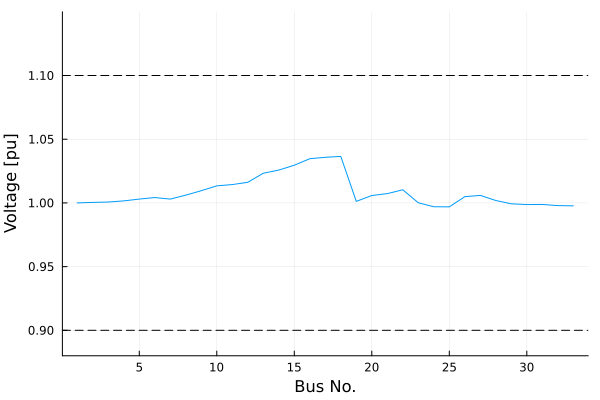

In [76]:
voltage=  XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/lowpvv2Revisedversionv0_hour14_0.1.xlsx", "lowpvv2Revisedversionv0_hour14_0.1","A2:A34")
voltage = vec(voltage)


using Plots
plot(legend = false, ylims=(0.88, 1.15), xlabel="Bus No.", ylabel="Voltage [pu]")
plot!(1:33, voltage, label=false) 
hline!([1.1, 0.9], color=:black, linestyle=:dash, label=false)

# Display the plot
display(plot!())

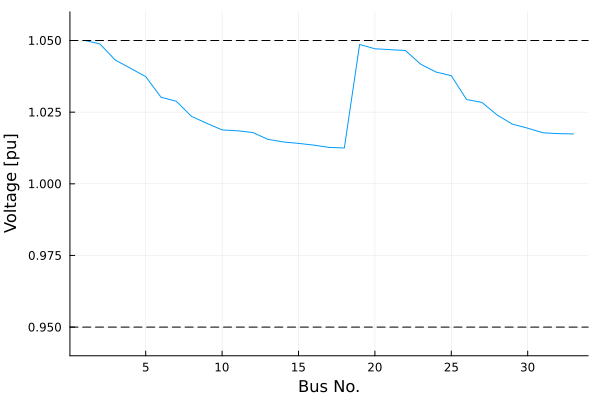

In [29]:
voltage=  XLSX.readdata("/Users/ebrah/Mehrnoush/lowpvv2Revisedversion_hour19_0.1.xlsx", "lowpvv2Revisedversion_hour19_0.1","A2:A34")
voltage = vec(voltage)


using Plots
plot(legend = false, ylims=(0.94, 1.06), xlabel="Bus No.", ylabel="Voltage [pu]")
plot!(1:33, voltage, label=false) 
hline!([1.05, 0.95], color=:black, linestyle=:dash, label=false)

# Display the plot
display(plot!())

# M_f

In [ ]:
# dualcc(epsilon) = XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/revisedversion_hour01_$(epsilon).xlsx", "revisedversion_hour01_$(epsilon)","F2")
# landa_cc(epsilon,f) = XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/revisedversion_hour01_$(epsilon).xlsx", "landa_cc","A$(f+1)")
# landa_third_cc = XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/revisedversion_hour01_$(epsilon).xlsx", "landa_third_cc","A$(f+1)")

htime = 1

epsilon_values=[1.0,0.1,0.01,0.005,0.001,0.0001]
allepsilons_1 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_1,  mue_epsilon)
end
allepsilons_1

In [ ]:

htime = 2

epsilon_values=[1.0,0.1,0.01,0.005,0.001,0.0001]
allepsilons_2 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_2,  mue_epsilon)
end
allepsilons_2

In [ ]:

htime = 3
epsilon_values=[1.0,0.1,0.01,0.005,0.001,0.0001]
allepsilons_3 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_3,  mue_epsilon)
end
allepsilons_3

In [ ]:

htime = 4
epsilon_values=[1.0,0.1,0.01,0.005,0.001,0.0001]
allepsilons_4 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_4,  mue_epsilon)
end
allepsilons_4

In [ ]:

htime = 5

epsilon_values=[1.0,0.1,0.01,0.005,0.001,0.0001]
allepsilons_5 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_5,  mue_epsilon)
end
allepsilons_5

In [ ]:

htime = 6
epsilon_values=[1.0,0.1,0.01,0.005,0.001,0.0001]
allepsilons_6 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_6,  mue_epsilon)
end
allepsilons_6

In [ ]:

htime = 7

epsilon_values=[1.0,0.1,0.01,0.005,0.001,0.0001]
allepsilons_7 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_7,  mue_epsilon)
end
allepsilons_7

In [ ]:

htime = 8
epsilon_values=[1.0,0.1,0.01,0.005,0.001,0.0001]
allepsilons_8 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_8,  mue_epsilon)
end
allepsilons_8

In [ ]:

htime = 9
epsilon_values=[1.0,0.1,0.01,0.005,0.001,0.0001]
allepsilons_9 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_9,  mue_epsilon)
end
allepsilons_9

In [ ]:

htime = 10
epsilon_values=[1.0,0.1,0.01,0.005,0.001,0.0001]
allepsilons_10 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_10,  mue_epsilon)
end
allepsilons_10

In [ ]:

htime = 11
epsilon_values=[1.0,0.1,0.01,0.005,0.001,0.0001]
allepsilons_11 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_11,  mue_epsilon)
end
allepsilons_11

In [ ]:

htime = 12

epsilon_values=[1.0,0.1,0.01,0.005,0.001,0.0001]
epsilon_values=[1.0,0.1,0.01,0.005,0.001,0.0001]
allepsilons_12 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_12,  mue_epsilon)
end
allepsilons_12

In [ ]:

htime = 13

epsilon_values=[0.1,0.01,0.005,0.001,0.0001]
allepsilons_13 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_13,  mue_epsilon)
end
allepsilons_13

In [ ]:

htime = 14
epsilon_values=[0.1,0.01,0.005,0.001,0.0001]
allepsilons_14 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_14,  mue_epsilon)
end
allepsilons_14

In [ ]:

htime = 15

epsilon_values=[0.1,0.01,0.005,0.001,0.0001]
allepsilons_15 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_15,  mue_epsilon)
end
allepsilons_15

In [ ]:

htime = 16

epsilon_values=[0.1,0.01,0.005,0.001,0.0001]
allepsilons_16 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_16,  mue_epsilon)
end
allepsilons_16

In [ ]:

htime = 17

epsilon_values=[0.1,0.01,0.005,0.001,0.0001]
allepsilons_17 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_17,  mue_epsilon)
end
allepsilons_17

In [ ]:

htime = 18
epsilon_values=[0.1,0.01,0.005,0.001,0.0001]
allepsilons_18 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_18,  mue_epsilon)
end
allepsilons_18

In [32]:

htime = 19
epsilon_values=[0.1,0.01,0.005,0.001,0.0001]
allepsilons_19 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/lowpvv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/lowpvv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "lowpvv2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/lowpvv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") 
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/lowpvv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/lowpvv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "lowpvv2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/lowpvv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/lowpvv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/lowpvv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:4)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/lowpvv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/lowpvv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "lowpvv2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/lowpvv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/lowpvv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/lowpvv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 5:6)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/lowpvv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/lowpvv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "lowpvv2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/lowpvv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/lowpvv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/lowpvv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 7:8)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/lowpvv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/lowpvv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "lowpvv2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/lowpvv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/lowpvv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/lowpvv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 9:10)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_19,  mue_epsilon)
end
allepsilons_19

Any[0.0, 2.9998, 3.0873, 10.0167, 3.908650131318259]Any[9.9683, 10.237962573887259, 9.979354739275944, 10.0192, 10.044065014132968]Any[10.0005, 10.204235701025048, 10.001641973432783, 10.0116, 10.026374493676224]Any[10.0219, 10.127804073316451, 10.002814873537444, 10.011213665535042, 10.023561192907092]Any[29.64187197786471, 23.023636176084224, 16.77877371933095, 22.68494656792878, 23.418523605468742]

5-element Vector{Any}:
 Any[0.0, 2.9998, 3.0873, 10.0167, 3.908650131318259]
 Any[9.9683, 10.237962573887259, 9.979354739275944, 10.0192, 10.044065014132968]
 Any[10.0005, 10.204235701025048, 10.001641973432783, 10.0116, 10.026374493676224]
 Any[10.0219, 10.127804073316451, 10.002814873537444, 10.011213665535042, 10.023561192907092]
 Any[29.64187197786471, 23.023636176084224, 16.77877371933095, 22.68494656792878, 23.418523605468742]

In [ ]:

htime = 20

epsilon_values=[0.1,0.01,0.005,0.001,0.0001]
allepsilons_20 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_20,  mue_epsilon)
end
allepsilons_20

# Grid search for htime = 19

In [60]:
htime = 19

19

In [23]:
#function run_optimization(epsilon)
    function run_optimization(epsilon)
    n_clusters = 5
#     ϵ = zeros(Float64, n_clusters)
#     for i in 1:n_clusters
#         ϵ[i] = epsilon
#     end 
    
     ϵ = [0.01,0.01,0.01,0.01,0.01]
     ϵ[5]=epsilon
    
    model = Model(SCS.Optimizer)
##############################################################
    n_clusters = 5
    N =nbuses
    D = n_clusters
    o= n_clusters
    Nprime = n_samples
    Vmax=1.1
    Vmin=0.9
    eta1 =0.05
    eta=0.05
    er=[]
    for j in 1:n_clusters
        er1= length(clusters[j])
        push!(er,er1)
    end    
    maximum(er)# the number of buses in the cluster which has the maximum buses
############################################################
    @variable(model,0 <= alpha[n=1:nbuses] <= 1) #variable for fraction of active power curtailed by RES
    @variable(model, qc[n=1:nPVs] ) #variable for reactive power provided by RES
    @variable(model, 0 <= pb[n=1: nenergy_storage_systems]) #variable for rate of (dis)charge for energy storage 
    # @variable(model, bb[n=1: nenergy_storage_systems]>= 0) #variable for state of charge of energy storage
    @variable(model, y1[n=1:nPVs] >=0)
    @variable(model, y2[n=1:nPVs] >=0)
    
    
    #auxillary variables for wc exp. cost reformulation
    @variable(model, λ_co[f=1:D] >=0)
    @variable(model, s_co1[n=1:N, i = 1:Nprime] >=0)
    @variable(model, s_co2[n=1:N, i = 1:Nprime] >=0)
    #@variable(model, S_cost[f=1:D, i=1:Nprime])
#     @variable(model, q[f=1:D, i=1:Nprime])
#     @variable(model, U[f=1:D, m=1:3*length(clusters[f]), i=1:Nprime] >=0)
#     @variable(model, L[f=1:D, m=1:3*length(clusters[f]), i=1:Nprime] >=0)
    # auxillary variables for CVaR reformulation
    @variable(model, varphi <=0)
    @variable(model, gamma[n=1:N] <=0)
    
    #DEFINE MATRISES
####################################################################    
        A = []
        for cluster in clusters
            cluster_size = length(cluster)
            delta_size = 3 * cluster_size
            aa = Array{AffExpr}(undef, nbuses, delta_size)
            for n in 1:nbuses
                for j in 1:cluster_size 
                    first =  R[n,cluster[j]]*(1-alpha[cluster[j]])
                    second=  -R[n,cluster[j]]
                    third = -B[n,cluster[j]]
                    # Add elements to the corresponding positions in the matrix A
                    aa[n,(j-1)*3+1] = first
                    aa[n,(j-1)*3+2] = second
                    aa[n,(j-1)*3+3] = third
                end
            end
            push!(A, aa)
        end
######################################################################
        AJ=vcat(A,-A,generalobj1)
         #a_prime= zeros(2*nbuses+1,n_clusters,3*maximum(er))
        a_prime = Array{AffExpr}(undef, 2*nbuses+1, n_clusters, 3*maximum(er))
        for i in 1:(2*nbuses+1)
            for j in 1:n_clusters
                for k in 1:3*maximum(er)
                    a_prime[i, j, k] = @expression(model, 0)
                end
            end
        end
        #a_prime = Array{AffExpr}(undef, 2*nbuses+1, n_clusters, 3*maximum(er))
        for b in 1:length(AJ)
            for c in 1:n_buses
                if b < n_clusters+1
                    if 3*length(clusters[b]) == 3*maximum(er)
                        for d in 1:3*maximum(er)
                            a_prime[c,b,d] = AJ[b][c,:][d]
                        end   
                    else
                        for d in 1:3*maximum(er)
                            if d < 3*length(clusters[b])+1
                                a_prime[c,b,d] = AJ[b][c,:][d]
                            else
                                a_prime[c,b,d]=0
                            end    
                        end    
                    end
                elseif b > n_clusters && b < 2*n_clusters+1 
                    if 3*length(clusters[b - n_clusters]) == 3*maximum(er)
                         for d in 1:3*maximum(er)
                             a_prime[c + nbuses,b - n_clusters,d] = AJ[b][c,:][d]
                         end   
                    else
                        for d in 1:3*maximum(er)
                            if d < 3*length(clusters[b - n_clusters])+1
                                a_prime[c + nbuses,b - n_clusters,d] = AJ[b][c,:][d]
                            else
                                 a_prime[c + nbuses,b - n_clusters,d]=0
                            end    
                         end  
                    end    
                else
                    if c == 1
                        if 3*length(clusters[b - 2*n_clusters]) == 3*maximum(er)
                            for d in 1:3*maximum(er) 
                                a_prime[c + 2*nbuses,b - 2*n_clusters,d] = AJ[b][c,:][d]
                            end    
                        else
                             for d in 1:3*maximum(er)
                                if d < 3*length(clusters[b - 2*n_clusters])+1
                                     a_prime[c + 2*nbuses,b - 2*n_clusters,d] =  AJ[b - 2*n_clusters][c,:][d]
                                else
                                    a_prime[c + 2*nbuses,b - 2*n_clusters,d]=0
                                end    
                             end           
                         end
                    end
                 end
             end
        end    

    ######################################################################
    # THIS MATRIX IS CREATED FOR USING IN MATRIX M   
        generalobj2 = []
        for cluster in clusters
            cluster_size = length(cluster)
            delta_size = 3 * cluster_size
            general2 = Array{AffExpr}(undef, 1, delta_size)
            for i in 1:1
                for j in 1:cluster_size
                    # p_av follows a normal distribution with mean 0 and std deviation of 10% of forecast
                    p_av_min = -c[cluster[j]]* (1-alpha[cluster[j]])+f[cluster[j]]*alpha[cluster[j]]
                    p_l_min=  c[cluster[j]] 
                    q_l_min = 0

                    general2[1,(j-1)*3+1] = p_av_min
                    general2[1,(j-1)*3+2] = p_l_min
                    general2[1,(j-1)*3+3] = q_l_min
                end
            end
            push!(generalobj2, general2)
        end
#######################################################################
    # matrix M
    # Initialize the matrix of vectors
    M = Array{Array{AffExpr, 1}}(undef, n_clusters, n_clusters)
    for i in 1:n_clusters
        for j in 1:n_clusters
            if i == j
                # If deltas_min[i] is already a vector, transpose and then convert to vector
                M[i, j] = vec(generalobj2[i])
            else
                M[i, j] = vec(zeros(1, 3 * length(clusters[j])))
            end
        end
    end
#################################################################


#########################################################
    @expression(model, b_first[t=1:nbuses], -R[t,:]'*pb +B[t,:]'*qc +a[t] - Vmax -varphi)
    @expression(model, b_second[t=1:nbuses], R[t,:]'*pb - B[t,:]'*qc -a[t] + Vmin -varphi)
    @expression(model, b_third_1[t=1:nbuses], qc[t]^2 - S_per_time_pu[htime][:][t]^2 - gamma[t])
    b_third_0= zeros(Float64, nbuses)
#*    @expression(model, v[n=1:nbuses],  A_filtered[n,:]'*sigma_hat_filtered_second_samples -R[n,:]'*pb +B[n,:]'*qc +a[n])# the definition of voltage in our model
    @expression(model, voltage[n=1:nbuses], sum(dot(A[f][n,:], deltas_min[f]) for f in 1:D) -R[n,:]'*pb +B[n,:]'*qc +a[n])# the definition of voltage in our model
    @expression(model, c_prime[i=1:2*nbuses+1], 
    if i <= nbuses
        b_first[i]  # The first 33 elements from b_first
    elseif i <= 2 * nbuses
        b_second[i - nbuses]  # The next 33 elements from b_second
    else
        0  # The 67th element is zero
    end
)
    @variable(model, varpi) 
    @variable(model, psi[n=1:N]) 
    ########################
    @variable(model, λ_cc[f=1:D] >=0) #related to constraint v[t] >= buses[t].Vmin and  v[t] =< buses[t].Vmax
    @variable(model, λ_third_cc[n=1:N ] >=0) # related to constraint ((1-alpha[PV.index])*pavs[PV.index])^2 + (qc[PV.index])^2 <= (PV.S)^2
    ##################
    @variable(model, P_cc[i=1:Nprime]>=0 )
    @variable(model, P[k=1:2*nbuses+1,f=1:D, i=1:Nprime] >=0)
    @variable(model, z[ k=1:2*nbuses+1,f=1:D, i=1:Nprime])
    @variable(model, u[ k=1:2*nbuses+1, f=1:D, m=1:3*length(clusters[f]), i=1:Nprime] >=0)
    @variable(model, l[ k=1:2*nbuses+1, f=1:D, m=1:3*length(clusters[f]), i=1:Nprime] >=0)
    ######################
    @variable(model, Z_cc[n=1:N, i=1:Nprime]>=0)
    #*#@variable(model, Z[n=1:N, f=1:D, i=1:Nprime])
     ###############
    @constraint(model,absolute[n=1:N] , qc[n] == y1[n] - y2[n]) 
    #Deterministic constraints
    for energy_storage_system in energy_storage_systems
    @constraint(model, pb[energy_storage_system.index] <= energy_storage_system.Pbmax) #Upper limit constraint for storage device
    @constraint(model, pb[energy_storage_system.index] >= -energy_storage_system.Pbmax)#Lower limit constraint for storage device
    end
    #Worst-case exp. cost aux. constraints
#     @constraint(model, mu_up[f=1:D, i=1:Nprime], S_cost[f,i] >= sum( q[f,i]*deltas_hat[f][m,:][i] + (U[f,m,i] * deltas_max[f][m] -L[f,m,i]* deltas_min[f][m]) for m in 1:3*length(clusters[f]))) 
#     @constraint(model, mu_lo[f=1:D, m=1:3*length(clusters[f]), i=1:Nprime], sum(M[o,:][f][m] for o in 1:D) - q[f,i] == U[f,m,i]- L[f,m,i])
#     @constraint(model, mu_av[f=1:D, i=1:Nprime],  q[f,i] >= -λ_cost[f])
#     @constraint(model, mu_av2[f=1:D, i=1:Nprime],  q[f,i] <= λ_cost[f])
    # CVaR reformulation of chance constraints
    @constraint(model, 0 >=varpi + varphi)
    @constraint(model,cvar_third[n=1:N],0 >= psi[n] + gamma[n])
    ###################################3
    constraint_ref = @constraint(model, eta1*varpi >= sum(λ_cc[f] * ϵ[f] for f in 1:D) + (1/Nprime) * sum(P_cc[i] for i in 1:Nprime))
    @constraint(model, DD1[k=1:2*nbuses+1, i=1:Nprime], P_cc[i] >= c_prime[k] + sum(P[k,f,i] for f in 1:D))
    @constraint(model, rhof1_up[k=1:2*nbuses+1, f=1:D, i=1:Nprime], P[k,f,i] >=  sum( z[k,f,i]*deltas_hat[f][m,:][i] + (u[k,f,m,i] * deltas_max[f][m] -l[k,f,m,i]* deltas_min[f][m]) for m in 1:3*length(clusters[f])))  
    @constraint(model, rhof1_lo[k=1:2*nbuses+1, f=1:D, m=1:3*length(clusters[f]), i=1:Nprime], a_prime[k,f,m]-z[k,f,i] == u[k,f,m,i]- l[k,f,m,i])
    @constraint(model, rhof1_av[k=1:2*nbuses+1, f=1:D, i=1:Nprime],    z[k,f,i] >= -λ_cc[f])
    @constraint(model, rhof1_av2[k=1:2*nbuses+1, f=1:D, i=1:Nprime],  z[k,f,i] <= λ_cc[f])
    ###########################################
    for n in 1:nbuses
        if dfpv_pu[n, :S] == 0.0
            @constraint(model, alpha[n]==0)
        end
    end

    
    constraint_refs = []
    for n in 1:nbuses
        if dfpv_pu[n, :S] != 0.0
            for cluster in clusters
                s_r= zeros(1,3*length(cluster))
                for j in 1:length(cluster)
                    if cluster[j] == n
                        indxofcluster = findfirst(x -> x == cluster, clusters)
                        s_r[1,(j-1)*3+1]=1
                        main_constraint_ref = @constraint(model,  eta * psi[n] >= λ_third_cc[n] * ϵ[indxofcluster]  + (1/Nprime) * sum(Z_cc[n,i] for i in 1:Nprime))
                        for i in 1:Nprime
                        @constraint(model, Z_cc[n,i] >= b_third_1[n] + ((1-alpha[n])*dot(s_r,deltas_max[indxofcluster]))^2 - λ_third_cc[n]*(dot(s_r,deltas_max[indxofcluster])-(s_r*deltas_hat[indxofcluster])[i]))
                        @constraint(model, Z_cc[n,i] >= b_third_1[n] + ((1-alpha[n])*(s_r*deltas_hat[indxofcluster])[i])^2)
                        #@constraint(model, Z_cc[n,i] >= -λ_third_cc[n] *(dot(s_r,deltas_max[indxofcluster])-(s_r*deltas_hat[indxofcluster])[i]))
                        # @constraint(model, Z_cc[n,i] >= λ_third_cc[n] *(dot(s_r,deltas_min[indxofcluster])-(s_r*deltas_hat[indxofcluster])[i]))
                        @constraint(model, Z_cc[n,i] >= 0)
                        end
                        push!(constraint_refs, main_constraint_ref)
                    end
                 end
             end 
        end   
     end
     
    
    
  
    
    obj_refs = []
    obj_refs2=[]
    for n in 1:nbuses
            totaltotal = 0 
            for cluster in clusters
                for j in 1:length(cluster)
                    if cluster[j] == n
                        r_n= zeros(1,3*length(cluster))
                        m_n= zeros(1,3*length(cluster))
                        indxofcluster = findfirst(x -> x == cluster, clusters)
                        m_n[1,(j-1)*3+1]=1
                        r_n[1,(j-1)*3+2]=1
                        #main_constraint_ref = @constraint(model,  eta * psi[n] >= λ_third_cc[n] * ϵ[indxofcluster]  + (1/Nprime) * sum(Z_cc[n,i] for i in 1:Nprime))
                        total1 = 0
                        total2=0
                        for i in 1:Nprime
                        @constraint(model, s_co1[n,i] >= c[n]*(dot(r_n,deltas_max[indxofcluster]) - (1-alpha[n])* (dot(m_n,deltas_min[indxofcluster])) + pb[n]) - λ_co[indxofcluster]*((dot(r_n,deltas_max[indxofcluster]) - (r_n*deltas_hat[indxofcluster])[i]) - (dot(m_n,deltas_min[indxofcluster]) - (m_n*deltas_hat[indxofcluster])[i])) )
                        @constraint(model, s_co1[n,i] >= d[n]*(-dot(r_n,deltas_min[indxofcluster]) + (1-alpha[n])* (dot(m_n,deltas_max[indxofcluster])) - pb[n]) - λ_co[indxofcluster]*((- dot(r_n,deltas_min[indxofcluster]) + (r_n*deltas_hat[indxofcluster])[i]) + (dot(m_n,deltas_max[indxofcluster]) - (m_n*deltas_hat[indxofcluster])[i])))
                        @constraint(model, s_co1[n,i] >= c[n]* ((r_n*deltas_hat[indxofcluster])[i]- (1-alpha[n])*(m_n*deltas_hat[indxofcluster])[i] + pb[n]))
                        @constraint(model, s_co1[n,i] >= d[n]* (-(r_n*deltas_hat[indxofcluster])[i]+ (1-alpha[n])*(m_n*deltas_hat[indxofcluster])[i] - pb[n]))
                        @constraint(model, s_co1[n,i] >= 0)
                        @constraint(model, s_co2[n,i] >= f[n]*alpha[n]*(dot(m_n,deltas_max[indxofcluster])) - λ_co[indxofcluster]*(dot(m_n,deltas_max[indxofcluster])- (m_n*deltas_hat[indxofcluster])[i] ))
                        @constraint(model, s_co2[n,i] >= f[n]*alpha[n]*(dot(m_n,deltas_min[indxofcluster])) + λ_co[indxofcluster]*(dot(m_n,deltas_min[indxofcluster])- (m_n*deltas_hat[indxofcluster])[i] ))
                        @constraint(model, s_co2[n,i] >= f[n]*alpha[n]* ((m_n*deltas_hat[indxofcluster])[i]))
                        @constraint(model, s_co2[n,i] >= 0)
                        total1 += s_co1[n,i]
                        total2 += s_co2[n,i]
                        end
                        push!(obj_refs, (1/Nprime) * total1)
                        push!(obj_refs2, (1/Nprime) * total2)
                    end
                 end
             end  
     end
     
    
    
    
    
    
    
    


#*    for n in 1:nbuses
#*        if dfpv_pu[n, :S] != 0.0
#*            @constraint(model,  eta * gamma[n] >= λ_third_cc[n] * ϵj[n]  + (1/Nprime) * sum(Z_cc[n,i] for i in 1:Nprime))
#*            for i in 1:Nprime
#*                 @constraint(model, Z_cc[n,i] >= b_third_1[n] + ((1-alpha[n])*sigma_max[n])^2 - λ_third_cc[n]*(sigma_max[n]-sigma_hat[n][i]))
#*                 @constraint(model, Z_cc[n,i] >= b_third_1[n] + ((1-alpha[n])*sigma_hat[n][i])^2)
#*                 @constraint(model, Z_cc[n,i] >= -λ_third_cc[n] *(sigma_max[n]-sigma_hat[n][i]))
#*                 @constraint(model, Z_cc[n,i] >= λ_third_cc[n] *(sigma_min[n]-sigma_hat[n][i]))
#*                 @constraint(model, Z_cc[n,i] >= 0)
#*            end   
#*        end
#*     end 
    #objective
    expcost = sum(λ_co[f]*ϵ[f] for f in 1:D)  + sum( obj_refs[n] + obj_refs2[n]  for n in 1:N) + sum(( e[n]* (y1[n]+y2[n])) for n in 1:N )
    @objective(model, Min,expcost)
    optimize!(model)
    obj_value = JuMP.objective_value(model)
v_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:voltage])]
qc_opt = [round(x, digits=4) for x in value.(model[:qc])]
alpha_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:alpha])]
pb_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:pb])]
λ_cc_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:λ_cc])]
λ_third_cc_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:λ_third_cc])[pvuncer_loc]]
λ_cost_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:λ_co])]
obj_value_opt = round(value.(obj_value), digits=4) 
    dual_value_cc = dual(constraint_ref)
    dual_value_inv=[]
    for ref in constraint_refs
        rr=zeros(length(pvuncer_loc),1)
        rr = dual(ref)
        push!(dual_value_inv,rr)
    end
    return v_opt,qc_opt, alpha_opt, pb_opt, λ_cc_opt, λ_third_cc_opt, λ_cost_opt, obj_value_opt,dual_value_cc,dual_value_inv
end

run_optimization (generic function with 1 method)

In [30]:
epsilon_values=[1]
# epsilon_values=[1]
for epsilon in epsilon_values
    result=run_optimization(epsilon)
    df_variables = DataFrame(  voltage= result[1], qc=  result[2], alpha=  result[3], pb= result[4])
    df_λ_cc= DataFrame(λ_cc= result[5])
    df_λ_third_cc= DataFrame(λ_third_cc =  result[6]) 
    df_λ_cost= DataFrame(λ_cost= result[7])
    df_objective= DataFrame(objective= result[8])
    df_dualcc= DataFrame(dualcc= result[9])
    df_dualinv= DataFrame(dualinv= result[10])
    ############## store the results for each epsilon in seperate excel files
    xlsx_file = XLSX.writetable("Grid_cluster5_hour$(htime)_$(epsilon).xlsx",df_variables, sheetname="Grid_cluster5_hour$(htime)_$(epsilon)")
    XLSX.openxlsx("Grid_cluster5_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        sheet = xf[1]
        XLSX.writetable!(sheet, df_objective, anchor_cell=XLSX.CellRef("E1"))
    end    
    XLSX.openxlsx("Grid_cluster5_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        sheet = xf[1]
        XLSX.writetable!(sheet, df_dualcc, anchor_cell=XLSX.CellRef("F1"))
    end  
    XLSX.openxlsx("Grid_cluster5_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "dualinv")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_dualinv)
    end
    XLSX.openxlsx("Grid_cluster5_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "landa_cc")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_λ_cc)
    end
    XLSX.openxlsx("Grid_cluster5_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "landa_third_cc")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_λ_third_cc)
    end
    XLSX.openxlsx("Grid_cluster5_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "landa_cost")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_λ_cost)
    end
end

------------------------------------------------------------------
	       SCS v3.2.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 70456, constraints m: 109779
cones: 	  z: primal zero / dual free vars: 33212
	  l: linear vars: 75807
	  q: soc vars: 760, qsize: 190
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
	  compiled with openmp parallelization enabled
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 265876, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 6.00e+02  3.00e+01  1.19e+06 -5.94e+05  1.00e-01  1.58e-01 
   250| 

# M_f for changing the epsilon for cluster 2 at time 15

In [ ]:


epsilon_values=[1]
allepsilons = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/Grid_cluster2_hour15_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/Grid_cluster2_hour15_$(epsilon).xlsx", "Grid_cluster2_hour15_$(epsilon)","F2") + XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/Grid_cluster2_hour15_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/Grid_cluster2_hour15_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/Grid_cluster2_hour15_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/Grid_cluster2_hour15_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/Grid_cluster2_hour15_$(epsilon).xlsx", "Grid_cluster2_hour15_$(epsilon)","F2") + XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/Grid_cluster2_hour15_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/Grid_cluster2_hour15_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/Grid_cluster2_hour15_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/Grid_cluster2_hour15_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/Grid_cluster2_hour15_$(epsilon).xlsx", "Grid_cluster2_hour15_$(epsilon)","F2") + XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/Grid_cluster2_hour15_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/Grid_cluster2_hour15_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/Grid_cluster2_hour15_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/Grid_cluster2_hour15_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/Grid_cluster2_hour15_$(epsilon).xlsx", "Grid_cluster2_hour15_$(epsilon)","F2") + XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/Grid_cluster2_hour15_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/Grid_cluster2_hour15_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/Grid_cluster2_hour15_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/Grid_cluster2_hour15_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/Grid_cluster2_hour15_$(epsilon).xlsx", "Grid_cluster2_hour15_$(epsilon)","F2") + XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/Grid_cluster2_hour15_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/Grid_cluster2_hour15_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("C:/Users/user/Data value in Distribution System paper 2024/Datacluster20samplesfinalHighpv/Grid_cluster2_hour15_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons,  mue_epsilon)
end
allepsilons

# ploting M_f for each f over 24 hours when epsilon is equal 0.01

In [ ]:
allm=(allepsilons_1,allepsilons_2,allepsilons_3,allepsilons_4,allepsilons_5,allepsilons_6,allepsilons_7,allepsilons_8,allepsilons_9,allepsilons_10,allepsilons_11,allepsilons_12,allepsilons_13,allepsilons_14,allepsilons_15,allepsilons_16,allepsilons_17,allepsilons_18,allepsilons_19,allepsilons_20,allepsilons_20,allepsilons_20,allepsilons_20,allepsilons_20)

In [ ]:
M_1_1 = [0,0,0,0,0,0,0,0,0,0,0,0,0,2.0254,2.093,2.0234,0,1.95,1.346,0,0,0,0,0]


M_1_01=[]
for i in 1:24
    if i <13
    aa=allm[i][2][1]
    push!(M_1_01,aa)
    else
        aa=allm[i][1][1]
    push!(M_1_01,aa)
    end   
end
M_1_01[18] = 10.001



M_1_001= [9.9792,10.0091,9.9959,10.0039,9.9932,9.991,10.0018,10.0086,9.9994,9.9993,10.000664996517889,10.284066705325532,9.9956,11.114525014307226,10.920273409889278,11.048736082315147,9.9981,11.04428332809599,10.991601565911344,9.9961,9.9961,9.9961,9.9961,9.9961]




M_1_0005=[]
for i in 1:24
    if i <13
    aa=allm[i][4][1]
    push!(M_1_0005,aa)
    else
        aa=allm[i][3][1]
    push!(M_1_0005,aa)
    end   
end
M_1_0005


M_1_0001=[]
for i in 1:24
    if i <13
    aa=allm[i][5][1]
    push!(M_1_0001,aa)
    else
        aa=allm[i][4][1]
    push!(M_1_0001,aa)
    end   
end
M_1_0001


M_1_00001=[]
for i in 1:24
    if i <13
    aa=allm[i][6][1]
    push!(M_1_00001,aa)
    else
        aa=allm[i][5][1]
    push!(M_1_00001,aa)
    end   
end
M_1_00001

In [ ]:
hours = ["12 AM", "1 AM", "2 AM", "3 AM", "4 AM", "5 AM", "6 AM", "7 AM", "8 AM", "9 AM", "10 AM", "11 AM", 
         "12 PM", "1 PM", "2 PM", "3 PM", "4 PM", "5 PM", "6 PM", "7 PM", "8 PM", "9 PM", "10 PM", "11 PM"]

plot(M_1_00001, title="M_1 over 24 hours for epsilon=0.01", xlabel="hour", ylabel="M_1", legend=false, linewidth=2, marker=:circle,xticks = (1:24,hours),xrotation=45)

In [ ]:
M_2_01=[]
for i in 1:24
    if i <13
    aa=allm[i][2][2]
    push!(M_2_01,aa)
    else
        aa=allm[i][1][2]
    push!(M_2_01,aa)
    end   
end
M_2_01[18] = 10.001



M_2_001=[]
for i in 1:24
    if i <13
    aa=allm[i][3][2]
    push!(M_2_001,aa)
    else
        aa=allm[i][2][2]
    push!(M_2_001,aa)
    end   
end



M_2_0005=[]
for i in 1:24
    if i <13
    aa=allm[i][4][2]
    push!(M_2_0005,aa)
    else
        aa=allm[i][3][2]
    push!(M_2_0005,aa)
    end   
end
M_2_0005


M_2_0001=[]
for i in 1:24
    if i <13
    aa=allm[i][5][2]
    push!(M_2_0001,aa)
    else
        aa=allm[i][4][2]
    push!(M_2_0001,aa)
    end   
end
M_2_0001


M_2_00001=[]
for i in 1:24
    if i <13
    aa=allm[i][6][2]
    push!(M_2_00001,aa)
    else
        aa=allm[i][5][2]
    push!(M_2_00001,aa)
    end   
end
M_2_00001

In [ ]:

hours = ["12 AM", "1 AM", "2 AM", "3 AM", "4 AM", "5 AM", "6 AM", "7 AM", "8 AM", "9 AM", "10 AM", "11 AM", 
         "12 PM", "1 PM", "2 PM", "3 PM", "4 PM", "5 PM", "6 PM", "7 PM", "8 PM", "9 PM", "10 PM", "11 PM"]

plot(M_2_00001, title="M_2 over 24 hours for epsilon=0.01", xlabel="Time of Day", ylabel="M_2", legend=false, linewidth=2, marker=:circle)

In [ ]:
M_2all= plot(1:24, [M_2_01,M_2_001,M_2_0005,M_2_0001,M_2_00001], label=["ϵ = 0.1" "ϵ = 0.01" "ϵ = 0.005"  "ϵ = 0.001" "ϵ = 0.0001"], color=[:orange :blue :red :green :purple :brown],
     xticks=(1:24, hours), xlabel="Time of Day", ylabel="\u03bc_1", linewidth=2.5, legend=:topleft, xrotation=45)
 M_1all= plot(1:24, [M_1_1,M_1_01,M_1_001,M_1_0005,M_1_0001,M_1_00001], label=["ϵ = 1" "ϵ = 0.1" "ϵ = 0.01" "ϵ = 0.005"  "ϵ = 0.001" "ϵ = 0.0001"], color=[:orange :blue :red :green :purple :brown],
     xticks=(1:24, hours), xlabel="Time of Day", ylabel="\u03bc_1", linewidth=2.5, legend=:topleft, xrotation=45)
# savefig(M_1all, "/Users/ebrah/Mehrnoush/m2.png")

In [ ]:
allM1over24at01=[]
for i in 1:24
    if i <13
        aa=allm[i][2][1]
        push!(allM1over24at01,aa)
    else
        aa=allm[i][1][1]
        push!(allM1over24at01,aa)
    end
end
allM1over24at01


allM2over24at01=[]
for i in 1:24
    if i <13
        aa=allm[i][2][2]
        push!(allM2over24at01,aa)
    else
        aa=allm[i][1][2]
        push!(allM2over24at01,aa)
    end
end
allM2over24at01


allM3over24at01=[]
for i in 1:24
    if i <13
        aa=allm[i][2][3]
        push!(allM3over24at01,aa)
    else
        aa=allm[i][1][3]
        push!(allM3over24at01,aa)
    end
end
allM3over24at01



allM4over24at01=[]
for i in 1:24
    if i <13
        aa=allm[i][2][4]
        push!(allM4over24at01,aa)
    else
        aa=allm[i][1][4]
        push!(allM4over24at01,aa)
    end
end
allM4over24at01


allM5over24at01=[]
for i in 1:24
    if i <13
        aa=allm[i][2][5]
        push!(allM5over24at01,aa)
    else
        aa=allm[i][1][5]
        push!(allM5over24at01,aa)
    end
end
allM5over24at01




################

allM1over24at001=[]
for i in 1:24
    if i <13
        aa=allm[i][3][1]
        push!(allM1over24at001,aa)
    else
        aa=allm[i][2][1]
        push!(allM1over24at001,aa)
    end
end
allM1over24at001


allM2over24at001=[]
for i in 1:24
    if i <13
        aa=allm[i][3][2]
        push!(allM2over24at001,aa)
    else
        aa=allm[i][2][2]
        push!(allM2over24at001,aa)
    end
end
allM2over24at001


allM3over24at001=[]
for i in 1:24
    if i <13
        aa=allm[i][3][3]
        push!(allM3over24at001,aa)
    else
        aa=allm[i][2][3]
        push!(allM3over24at001,aa)
    end
end
allM3over24at001



allM4over24at001=[]
for i in 1:24
    if i <13
        aa=allm[i][3][4]
        push!(allM4over24at001,aa)
    else
        aa=allm[i][2][4]
        push!(allM4over24at001,aa)
    end
end
allM4over24at001


allM5over24at001=[]
for i in 1:24
    if i <13
        aa=allm[i][3][5]
        push!(allM5over24at001,aa)
    else
        aa=allm[i][2][5]
        push!(allM5over24at001,aa)
    end
end
allM5over24at001

################







allM1over24at0005=[]
for i in 1:24
    if i <13
        aa=allm[i][4][1]
        push!(allM1over24at0005,aa)
    else
        aa=allm[i][3][1]
        push!(allM1over24at0005,aa)
    end
end
allM1over24at0005


allM2over24at0005=[]
for i in 1:24
    if i <13
        aa=allm[i][4][2]
        push!(allM2over24at0005,aa)
    else
        aa=allm[i][3][2]
        push!(allM2over24at0005,aa)
    end
end
allM2over24at0005


allM3over24at0005=[]
for i in 1:24
    if i <13
        aa=allm[i][4][3]
        push!(allM3over24at0005,aa)
    else
        aa=allm[i][3][3]
        push!(allM3over24at0005,aa)
    end
end
allM3over24at0005



allM4over24at0005=[]
for i in 1:24
    if i <13
        aa=allm[i][4][4]
        push!(allM4over24at0005,aa)
    else
        aa=allm[i][3][4]
        push!(allM4over24at0005,aa)
    end
end
allM4over24at0005


allM5over24at0005=[]
for i in 1:24
    if i <13
        aa=allm[i][4][5]
        push!(allM5over24at0005,aa)
    else
        aa=allm[i][3][5]
        push!(allM5over24at0005,aa)
    end
end
allM5over24at0005


######################





allM1over24at0001=[]
for i in 1:24
    if i <13
        aa=allm[i][5][1]
        push!(allM1over24at0001,aa)
    else
        aa=allm[i][4][1]
        push!(allM1over24at0001,aa)
    end
end
allM1over24at0001


allM2over24at0001=[]
for i in 1:24
    if i <13
        aa=allm[i][5][2]
        push!(allM2over24at0001,aa)
    else
        aa=allm[i][4][2]
        push!(allM2over24at0001,aa)
    end
end
allM2over24at0001


allM3over24at0001=[]
for i in 1:24
    if i <13
        aa=allm[i][5][3]
        push!(allM3over24at0001,aa)
    else
        aa=allm[i][4][3]
        push!(allM3over24at0001,aa)
    end
end
allM3over24at0001



allM4over24at0001=[]
for i in 1:24
    if i <13
        aa=allm[i][5][4]
        push!(allM4over24at0001,aa)
    else
        aa=allm[i][4][4]
        push!(allM4over24at0001,aa)
    end
end
allM4over24at0001


allM5over24at0001=[]
for i in 1:24
    if i <13
        aa=allm[i][5][5]
        push!(allM5over24at0001,aa)
    else
        aa=allm[i][4][5]
        push!(allM5over24at0001,aa)
    end
end
allM5over24at0001


##########




allM1over24at00001=[]
for i in 1:24
    if i <13
        aa=allm[i][6][1]
        push!(allM1over24at00001,aa)
    else
        aa=allm[i][5][1]
        push!(allM1over24at00001,aa)
    end
end
allM1over24at00001


allM2over24at00001=[]
for i in 1:24
    if i <13
        aa=allm[i][6][2]
        push!(allM2over24at00001,aa)
    else
        aa=allm[i][5][2]
        push!(allM2over24at00001,aa)
    end
end
allM2over24at00001


allM3over24at00001=[]
for i in 1:24
    if i <13
        aa=allm[i][6][3]
        push!(allM3over24at00001,aa)
    else
        aa=allm[i][5][3]
        push!(allM3over24at00001,aa)
    end
end
allM3over24at00001



allM4over24at00001=[]
for i in 1:24
    if i <13
        aa=allm[i][6][4]
        push!(allM4over24at00001,aa)
    else
        aa=allm[i][5][4]
        push!(allM4over24at00001,aa)
    end
end
allM4over24at00001


allM5over24at00001=[]
for i in 1:24
    if i <13
        aa=allm[i][6][5]
        push!(allM5over24at00001,aa)
    else
        aa=allm[i][5][5]
        push!(allM5over24at00001,aa)
    end
end
allM5over24at00001















In [ ]:
Mdifferent001= plot(1:24, [allM1over24at001,allM2over24at001,allM3over24at001,allM4over24at001,allM5over24at001], label=["1" "2" "3"  "4" "5"], color=[:orange :blue :red :green :purple ],
     xticks=(1:24, hours), xlabel="Time of Day", ylabel="\u03bc_f", linewidth=2.5, legend=:topleft, xrotation=45)

In [ ]:
using Plots

# Create 6 separate plots
# p1 = plot(1:24, [allM1over24at1,allM2over24at1,allM3over24at1,allM4over24at1,allM5over24at1], label=["f=1" "f=2" "f=3"  "f=4" "f=5"], color=[:orange :blue :red :green :purple ],
#      xticks=(1:24, hours), xlabel="Time of Day", ylabel="\u03bc_f", linewidth=2.5, legend=:topleft, xrotation=45)

# p2 = plot(1:24, [allM1over24at01,allM2over24at01,allM3over24at01,allM4over24at01,allM5over24at01], label=["f=1" "f=2" "f=3"  "f=4" "f=5"], color=[:orange :blue :red :green :purple ],
#      xticks=(1:24, hours), xlabel="Time of Day", ylabel="\u03bc_f", linewidth=2.5, legend=:topleft, xrotation=45)

p3 = plot(1:24, [allM1over24at001,allM2over24at001,allM3over24at001,allM4over24at001,allM5over24at001], label=["f=1" "f=2" "f=3"  "f=4" "f=5"], color=[:orange :blue :red :green :purple ],
     xticks=(1:24, hours), ylabel="\u03bc_f", title = "ϵ = 0.01",linewidth=2.5, legend=:topleft, xrotation=45)

p4 = plot(1:24, [allM1over24at0005,allM2over24at0005,allM3over24at0005,allM4over24at0005,allM5over24at0005], label=["f=1" "f=2" "f=3"  "f=4" "f=5"], color=[:orange :blue :red :green :purple ],
     xticks=(1:24, hours),  ylabel="\u03bc_f",title = "ϵ = 0.005", linewidth=2.5, legend=:topleft, xrotation=45)

p5 = plot(1:24, [allM1over24at0001,allM2over24at0001,allM3over24at0001,allM4over24at0001,allM5over24at0001], label=["f=1" "f=2" "f=3"  "f=4" "f=5"], color=[:orange :blue :red :green :purple ],
     xticks=(1:24, hours), xlabel="Time of Day",title = "ϵ = 0.001", ylabel="\u03bc_f", linewidth=2.5, legend=:topleft, xrotation=45)

# p6 = plot(1:24, [allM1over24at00001,allM2over24at00001,allM3over24at00001,allM4over24at00001,allM5over24at00001], label=["f=1" "f=2" "f=3"  "f=4" "f=5"], color=[:orange :blue :red :green :purple ],
#      xticks=(1:24, hours), xlabel="Time of Day", ylabel="\u03bc_f", linewidth=2.5, legend=:topleft, xrotation=45)

# Combine them into a 3x2 grid
plots = [p3 p4 p5 ]

# Display the combined plot
differentmu=plot(plots..., layout=(3, 1), size=(600, 400))
savefig(differentmu, "/Users/ebrah/Mehrnoush/threeeosilons.pdf")

# Ou of sample test

load data

In [45]:

# Assuming you've read your dataset into a DataFrame called df
df = CSV.read("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/data/loaddata/time_series_60min_singleindex - Copy.csv", DataFrame)
# Define the normalization function
function normalize_column!(col::AbstractVector{T}) where T<:Real
    min_val = minimum(col)
    max_val = maximum(col)
    return (col) / (max_val)
end
# Apply the normalization to each numeric column
for col_name in names(df)
    if eltype(df[!, col_name]) <: Real
        df[!, col_name] = normalize_column!(df[!, col_name])
    end
end




# Define the format of your timestamps
dateformat = "yyyy-mm-dd\\THH:MM:SSZ"
# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("2015-01-02T00:00:00Z", dateformat)
end_time = DateTime("2015-01-03T00:00:00Z", dateformat)
df_24h = filter(row -> start_time <= DateTime(row[:utc_timestamp], dateformat) < end_time, df)
# Ensure that the column names are correct and that they are Symbols
# Plot the load data, using the correct column accessors
aanor = plot(df_24h.utc_timestamp, df_24h.AT_load_actual_entsoe_transparency, label="Actual Load", xlabel="Time", ylabel="Load", title="Load Data for 24 Hours", xrotation=45) # Rotates X-axis labels to make them readable
#savefig(aanor, "C:/Users/user/OneDrive - Rutgers University/Desktop/PHD- research/loadDataPlotnorm.png")





Vbase = 12.66 * 1e3;  # in Volts#basekV=12.66
Sbase = 1. * 1e6;  #in VA #baseMVA=1

cum24hourseachbus = []
for i in 1:33
    eachbus = df_24h.AT_load_actual_entsoe_transparency.* dfb[!,"Pd"][i].* 1e3.*0.5 ./ Sbase
    push!(cum24hourseachbus,eachbus)
end





# Define the format of your timestamps
dateformat = "yyyy-mm-dd\\THH:MM:SSZ"
# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("2015-01-02T00:00:00Z", dateformat)
end_time = DateTime("2015-01-03T00:00:00Z", dateformat)
df_24h = filter(row -> start_time <= DateTime(row[:utc_timestamp], dateformat) < end_time, df)
# Ensure that the column names are correct and that they are Symbols
# Plot the load data, using the correct column accessors
aanor = plot(df_24h.utc_timestamp, cum24hourseachbus[4], label="Actual Load", xlabel="Time", ylabel="Load", title="Load Data for 24 Hours", xrotation=45) # Rotates X-axis labels to make them readable
#savefig(aanor, "C:/Users/user/OneDrive - Rutgers University/Desktop/PHD- research/loadDataPlotnorm.png")




cumbuseachhour = []
for i in 1:24
    eachhour = df_24h.AT_load_actual_entsoe_transparency[i].* dfb[!,"Pd"].* 1e3.*0.5 ./ Sbase
    push!(cumbuseachhour,eachhour)
end    



cumbuseachhourreactiveload = []
for i in 1:24
    eachhourreactiveload = df_24h.AT_load_actual_entsoe_transparency[i].* dfb[!,"Qd"].* 1e3.*0.5 ./ Sbase
    push!(cumbuseachhourreactiveload,eachhourreactiveload )
end  


PV data

In [154]:
using CSV
using DataFrames
using HTTP
using CSV
using DataFrames
using Dates
using Plots



data_url = "https://raw.githubusercontent.com/mieth-robert/testdata/main/single_household_smart_home.csv"
response = HTTP.get(data_url)
smart_home_data = CSV.File(IOBuffer(response.body)) |> DataFrame



smart_home_data[!, :local_15min] = DateTime.(smart_home_data[!, :local_15min], "m/d/y H:M")
# Load your smart_home_data DataFrame here
# smart_home_data = ...

# Define the format of your timestamps
dateformat = "m/d/y H:M"

# Ensure 'local_15min' is parsed to DateTime format if it's not already
#smart_home_data[!, :local_15min] = DateTime.(smart_home_data[!, :local_15min], dateformat)

# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("3/2/15 0:0", dateformat)
end_time = DateTime("3/3/15 0:0", dateformat)
df_24h = filter(row -> start_time <= row[:local_15min] < end_time, smart_home_data)

# Further filter to get only the start of each hour
df_hourly = df_24h[minute.(df_24h[!, :local_15min]) .== 0, :]

# Plot the solar data
plt = plot(df_hourly.local_15min, df_hourly.solar, label="Solar Energy", xlabel="Time", ylabel="Energy", title="Solar Energy Data for March 3, 2015", xrotation=45)






function normalize_column!(col::AbstractVector{T}) where T<:Real
    min_val = minimum(col)
    max_val = maximum(col)
    return (col) / (max_val)
end
# Apply the normalization to each numeric column
for col_name in names( df_hourly)
    if eltype( df_hourly[!, col_name]) <: Real
         df_hourly[!, col_name] = normalize_column!( df_hourly[!, col_name])
    end
end








# Define the format of your timestamps if your 'local_15min' column is in string format that needs parsing
dateformat = "m/d/y H:M"

# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("3/2/15 0:0", dateformat)
end_time = DateTime("3/3/15 0:0", dateformat)
df_24h = filter(row -> start_time <= row[:local_15min] < end_time, df_hourly)
# Ensure that the column names are correct and that they are Symbols
# Plot the solar data
aanor = plot(df_24h.local_15min, df_24h.solar, label="Solar Energy", xlabel="Time", ylabel="Energy", title="Solar Energy Data for March 3, 2015", xrotation=45)











Vbase = 12.66 * 1e3;  # in Volts#basekV=12.66
Sbase = 1. * 1e6;  #in VA #baseMVA=1
df_24h.solar[21] = 0.0005
cum24hourseachbuspv = []
for i in 1:33
    eachbuspv = df_24h.solar.* dfpv[!, :S][i].*2# here we multiply each curve (24 hours) by a single value corres
    push!(cum24hourseachbuspv,eachbuspv)
end




cumbuseachhourpv = []
for i in 1:24
    eachhourpv = df_24h.solar[i].* dfpv[!, :S].*2 # here we scale the system capacity for all 33 buses at one specific hour by multiplying the sysytem capacity for all 33 buse by the amount of genereated pv (curve) at one specific time. then we repeat ut 24 hours for all hours. so we have 24 33dimension vectors.
    push!(cumbuseachhourpv,eachhourpv)
end    
cumbuseachhourpv[10][:]




pvcum = []
for h in 1:24
    Random.seed!(123)
    pav = rand(length(cumbuseachhourpv[h][:])) .* cumbuseachhourpv[h][:] # Generate random scaling factors between 0 and 1 and then Scale the values between 0 and 100% of system capacity in each hour , it means that we have generated pv a 33 colum vector data for each hour in 24 hours
    pavs = pav .* 1e3 ./ Sbase 
    push!(pvcum,pavs)
end  
pvcum


24-element Vector{Any}:
 [0.0, 0.0, 0.00021123891816980005, 0.0, 7.191192321289225e-5, 0.00014199073783934232, 0.0, 0.00019661126351409817, 0.0, 0.0  …  0.0, 9.705421098469855e-6, 0.0, 0.00027397088168331556, 0.0, 0.0002799964860971234, 0.0, 0.00015150883439876779, 0.0, 0.00026375630249864964]
 [0.0, 0.0, 0.00021123891816980005, 0.0, 7.191192321289225e-5, 0.00014199073783934232, 0.0, 0.00019661126351409817, 0.0, 0.0  …  0.0, 9.705421098469855e-6, 0.0, 0.00027397088168331556, 0.0, 0.0002799964860971234, 0.0, 0.00015150883439876779, 0.0, 0.00026375630249864964]
 [0.0, 0.0, 0.00021123891816980005, 0.0, 7.191192321289225e-5, 0.00014199073783934232, 0.0, 0.00019661126351409817, 0.0, 0.0  …  0.0, 9.705421098469855e-6, 0.0, 0.00027397088168331556, 0.0, 0.0002799964860971234, 0.0, 0.00015150883439876779, 0.0, 0.00026375630249864964]
 [0.0, 0.0, 0.00021123891816980005, 0.0, 7.191192321289225e-5, 0.00014199073783934232, 0.0, 0.00019661126351409817, 0.0, 0.0  …  0.0, 9.705421098469855e-6, 0.0, 0.

In [155]:
S_per_time_pu=cumbuseachhourpv.* 1e3 ./ Sbase

24-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.00028328611898017006, 0.0, 0.00028328611898017006, 0.000424929178470255, 0.0, 0.000226628895184136, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.000339943342776204, 0.0, 0.000339943342776204, 0.0, 0.000169971671388102, 0.0, 0.000453257790368272]
 [0.0, 0.0, 0.00028328611898017006, 0.0, 0.00028328611898017006, 0.000424929178470255, 0.0, 0.000226628895184136, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.000339943342776204, 0.0, 0.000339943342776204, 0.0, 0.000169971671388102, 0.0, 0.000453257790368272]
 [0.0, 0.0, 0.00028328611898017006, 0.0, 0.00028328611898017006, 0.000424929178470255, 0.0, 0.000226628895184136, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.000339943342776204, 0.0, 0.000339943342776204, 0.0, 0.000169971671388102, 0.0, 0.000453257790368272]
 [0.0, 0.0, 0.00028328611898017006, 0.0, 0.00028328611898017006, 0.000424929178470255, 0.0, 0.000226628895184136, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.00033994334277620

In [156]:
using Printf

# Function to adjust and format numbers, keeping them as numbers
function adjust_and_format_number(num)
    if abs(num) < 1e-4
        return 0.0
    else
        return round(num, digits=4)
    end
end

# Apply the function to each number in the vector pvcum
pvcum = map(sublist -> map(adjust_and_format_number, sublist), pvcum)

# Displaying a sample from the result
println(pvcum[10])

# Apply the same process for other vectors
cumbuseachhour = map(sublist -> map(adjust_and_format_number, sublist), cumbuseachhour)
println(cumbuseachhour[10])

cumbuseachhourreactiveload = map(sublist -> map(adjust_and_format_number, sublist), cumbuseachhourreactiveload)
println(cumbuseachhourreactiveload[10])


[0.0, 0.0, 0.0249, 0.0, 0.0085, 0.0168, 0.0, 0.0232, 0.0, 0.0, 0.0347, 0.0073, 0.0, 0.0047, 0.0, 0.0321, 0.0104, 0.0061, 0.004, 0.0, 0.0299, 0.0119, 0.0018, 0.0, 0.0011, 0.0, 0.0323, 0.0, 0.033, 0.0, 0.0179, 0.0, 0.0311]
[0.0, 0.0486, 0.0438, 0.0583, 0.0292, 0.0292, 0.0972, 0.0972, 0.0292, 0.0292, 0.0219, 0.0292, 0.0292, 0.0583, 0.0292, 0.0292, 0.0292, 0.0438, 0.0438, 0.0438, 0.0438, 0.0438, 0.0438, 0.2042, 0.2042, 0.0292, 0.0292, 0.0292, 0.0583, 0.0972, 0.0729, 0.1021, 0.0292]
[0.0, 0.0292, 0.0194, 0.0389, 0.0146, 0.0097, 0.0486, 0.0486, 0.0097, 0.0097, 0.0146, 0.017, 0.017, 0.0389, 0.0049, 0.0097, 0.0097, 0.0194, 0.0194, 0.0194, 0.0194, 0.0194, 0.0243, 0.0972, 0.0972, 0.0122, 0.0122, 0.0097, 0.034, 0.2917, 0.034, 0.0486, 0.0194]


In [157]:
# define location of files

htime= 19

#define voltage base and Sbase 
Vbase = 12.66 * 1e3;  # in Volts#basekV=12.66
Sbase = 1. * 1e6;  #in VA #baseMVA=1

#convert impedances from Ohms to p.u. - loads from kW to pu - battery data from kw to pu - pv data from kw to pu
dfb_pu = DataFrame()
for row in eachrow(dfb)
    newdfb = (index=row.index, Node = row.Node, Pd=row.Pd .* 1e3.*0.5 ./ Sbase, Qd=row.Qd.*0.5 .* 1e3 ./ Sbase, Vmax=1.1, Vmin=0.9, r=row.r ./(Vbase^2 / Sbase), x=row.x ./(Vbase^2 / Sbase), b= row.b)
    push!(dfb_pu, newdfb)
end

dfl_pu = DataFrame()
for row in eachrow(dfl)
    newdfl = (index=row.index, to = row.to , from=row.from , r=row.r ./  (Vbase^2 / Sbase), x=row.x ./ (Vbase^2 / Sbase), b=row.b, s=row.s, g = row.g)
    push!(dfl_pu, newdfl)
end

dfbat_pu = DataFrame()
for row in eachrow(dfbat)
    newdfbat = (index=row.index, Node = row.Node , bmax=row.bmax .* 1e3 ./ Sbase , pmax=row.pmax .* 1e3 ./ Sbase )
    push!(dfbat_pu, newdfbat)
end

dfpv_pu = DataFrame()
for row in eachrow(dfpv)
    newdfpv = (index=row.index, Node = row.Node , S = row.S .* 1e3.*2 ./ Sbase )
    push!(dfpv_pu, newdfpv)
end


# bring the data in a more useable form
println(">>> preparing data")
buses = []
for row in eachrow(dfb_pu)
    newbus = (index=row.index, ancestor=[], children=[], pd=row.Pd, qd=row.Qd, Vmax=row.Vmax, Vmin = row.Vmin)
    push!(buses, newbus)
end

lines = []
for row in eachrow(dfl_pu)
    newline = (index=row.index, r=row.r, x=row.x, from=row.to, to=row.from)
    push!(buses[newline.to].ancestor, newline.from)
    push!(buses[newline.from].children, newline.to)
    push!(lines, newline)
end

PVs = []
for row in eachrow(dfpv_pu)
    newPV = (index=row.index, S=row.S)
    push!(PVs, newPV)
end

energy_storage_systems = []
for row in eachrow(dfbat_pu)
    newenergy_storage_system = (index=row.index, Pbmax=row.pmax,Bmax = row.bmax )
    push!(energy_storage_systems, newenergy_storage_system)
end

nbuses = length(buses)
nlines = length(lines)
nPVs = length(PVs)
nenergy_storage_systems = length(energy_storage_systems)

# now compute the same thing in the matrix form
println(">>> compute matrizes")
# define A matrix (with substation bus!)
A = zeros(length(lines), length(buses))
for bus in buses
    a = bus.index
    while a != 1
        A[a-1, bus.index] = 1
        a = buses[a].ancestor[1]
    end
end

# define load active and reactive power vectors
pl= cumbuseachhour[htime]
ql = cumbuseachhourreactiveload[htime]
pav_pu = pvcum[htime]




# Random.seed!(123)
# random_factors = 1 .* rand(length(dfpv[!, :S])) 
# pav = random_factors .* dfpv[!, :S]
# pav_pu=pav .* 1e3 ./ Sbase 
######################################



# define power generation vectors
#Random.seed!(123)
#pav = rand(length(dfpv_pu[!, :S])) .* dfpv_pu[!, :S] # Generate random scaling factors between 0 and 1 and then Scale the values between 0 and 100%

#pavs = pav .* 5

# set substation voltage
u_0 = 1

# define remaining matrizes
diag_r = Diagonal([line.r for line in lines])
diag_x = Diagonal([line.x for line in lines])
R = 2*A'*diag_r*A
B = 2*A'*diag_x*A
a = ones(nbuses) .* u_0 


# define parameters relatedd to the price
c = fill(10, nbuses) #the price associated with the power consumed by the customers
d= fill(3, nbuses) # the feed-in tariff cost to the utility
e= fill(30, nbuses) # the cost of reactive power injection/absorption from the inverters
f= fill(6,nbuses) # the cost of active power curtailment

>>> preparing data
>>> compute matrizes


33-element Vector{Int64}:
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 ⋮
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6

In [158]:
forecast_values = hcat(pav_pu,pl,ql)

33×3 Matrix{Float64}:
 0.0     0.0     0.0
 0.0     0.0421  0.0253
 0.1802  0.0379  0.0169
 0.0     0.0506  0.0337
 0.0613  0.0253  0.0126
 0.1211  0.0253  0.0084
 0.0     0.0843  0.0421
 0.1677  0.0843  0.0421
 0.0     0.0253  0.0084
 0.0     0.0253  0.0084
 0.2509  0.019   0.0126
 0.0528  0.0253  0.0148
 0.0     0.0253  0.0148
 ⋮               
 0.0858  0.0379  0.0169
 0.0127  0.0379  0.0211
 0.0     0.177   0.0843
 0.0083  0.177   0.0843
 0.0     0.0253  0.0105
 0.2337  0.0253  0.0105
 0.0     0.0253  0.0084
 0.2388  0.0506  0.0295
 0.0     0.0843  0.2529
 0.1292  0.0632  0.0295
 0.0     0.0885  0.0421
 0.225   0.0253  0.0169

In [159]:
# Function to create clusters
function create_clusters(n_buses, n_clusters)
    Random.seed!(123)
    buses = collect(1:n_buses) # Create a list of buses
    clusters = [Int[] for _ in 1:n_clusters] # Initialize clusters

    while length(buses) > 0
        for cluster in clusters
            if length(buses) == 0
                break
            end
            # Randomly choose a bus to be in this cluster
            bus_index = rand(1:length(buses))
            bus = buses[bus_index]

            # Add the bus to the current cluster
            push!(cluster, bus)

            # Remove the bus from the list of buses
            deleteat!(buses, bus_index)

            # Sort the cluster to ensure buses are close together
            sort!(cluster)
        end
    end
    return clusters
end

# Define the number of buses and clusters
n_buses = 33
n_clusters = 5

5

In [160]:
clusters= [[1,2,3,4,5,6,7,8,9,10],[11,12,13,14,15,16,17,18],[19,20,21,22],[23,24,25],[26,27,28,29,30,31,32,33]]

5-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 [11, 12, 13, 14, 15, 16, 17, 18]
 [19, 20, 21, 22]
 [23, 24, 25]
 [26, 27, 28, 29, 30, 31, 32, 33]

In [161]:
F=pl./ql
F[1]=0

0

In [162]:
N_main=200

200

In [163]:
Random.seed!(123)
# Function to create samples for vector deltas
function create_delta_samples(clusters, forecast_values, n_samples)
    deltas_samples = []

    # For each cluster, create samples for delta vector
    for cluster in clusters
        cluster_size = length(cluster)
        delta_size = 3 * cluster_size
        samples = zeros(delta_size, n_samples)

        # Create samples
        for i in 1:n_samples
            for j in 1:cluster_size
                # p_av follows a normal distribution with mean 0 and std deviation of 10% of forecast
                p_av_forecast = forecast_values[cluster[j], 1]
                p_av_std = 0.4 * p_av_forecast
                p_av_dist = Normal(0, p_av_std)
                p_av_sample = rand(p_av_dist)
                p_av_sample = min.(p_av_sample, S_per_time_pu[htime][:][cluster[j]] - pav_pu[cluster[j]])
                p_av_sample = max.(p_av_sample, - pav_pu[cluster[j]])

                # p_l is uniformly sampled between 0.5 and 1 of forecast
                # q_l is uniformly sampled between 0.9 and 1.1 of forecast
                p_l_forecast = forecast_values[cluster[j], 2]
                p_l_std = 0.4 * p_l_forecast
                p_l_dist = Normal(0, p_l_std)
                p_l_sample = rand(p_l_dist)
                p_l_sample = min.(p_l_sample, 1.2 * p_l_forecast - p_l_forecast)
                p_l_sample = max.(p_l_sample, 0.5 * p_l_forecast- p_l_forecast)
                
                if F[cluster[j]] == 0
                    q_l_sample= 0
                else    
                    q_l_sample = (p_l_sample + p_l_forecast) ./ F[cluster[j]]
                end
                
                # Add samples to the corresponding positions in the delta vector
                samples[(j-1)*3+1, i] = p_av_sample + p_av_forecast
                samples[(j-1)*3+2, i] = p_l_sample + p_l_forecast
                samples[(j-1)*3+3, i] = q_l_sample
            end
        end

        # Add the samples for this cluster's delta to the list
        push!(deltas_samples, samples)
    end
    return deltas_samples
end







# Create the samples for vector deltas
n_samples = 5# Number of samples for each vector delta
X = create_delta_samples(clusters, forecast_values, N_main)
Y1 = X[1][:, sample(1:N_main, n_samples, replace = false)]
Y2 = X[2][:, sample(1:N_main, n_samples, replace = false)]
Y3 = X[3][:, sample(1:N_main, n_samples, replace = false)]
Y4 = X[4][:, sample(1:N_main, n_samples, replace = false)]
Y5 = X[5][:, sample(1:N_main, n_samples, replace = false)]


24×5 Matrix{Float64}:
 0.0         0.0         0.0         0.0         0.0
 0.0200897   0.0300149   0.03036     0.03036     0.0241612
 0.00833763  0.0124568   0.0126      0.0126      0.0100274
 0.0660264   0.12298     0.289972    0.0154182   0.108644
 0.0299472   0.013131    0.0270388   0.0149596   0.0303095
 0.0124287   0.00544962  0.0112216   0.00620854  0.012579
 0.0         0.0         0.0         0.0         0.0
 0.0293456   0.01265     0.0186557   0.0225151   0.0224653
 0.00974319  0.0042      0.00619398  0.00747538  0.00745885
 0.0701237   0.289972    0.252471    0.272162    0.0498107
 0.06072     0.06072     0.06072     0.0448939   0.0338783
 0.0354      0.0354      0.0354      0.0261733   0.0197512
 0.0         0.0         0.0         0.0         0.0
 0.10116     0.10116     0.0869232   0.0548583   0.0974803
 0.30348     0.30348     0.260769    0.164575    0.292441
 0.0941666   0.144986    0.108887    0.144986    0.144986
 0.0627251   0.0352664   0.061559    0.0679467   0.0665

In [164]:
deltas_samples = [Y1,Y2,Y3,Y4,Y5]

5-element Vector{Matrix{Float64}}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.014219101572695965 0.01265 … 0.01265 0.014232186368362636; 0.004720966530065064 0.0042 … 0.0042 0.0047253108891006385]
 [0.1969372734820702 0.30827472092286745 … 0.05373613993710227 0.2584015184608193; 0.0095 0.0095 … 0.022799999999999997 0.0211398765570657; … ; 0.04548 0.01895 … 0.01895 0.04259600008509351; 0.020279999999999996 0.00845 … 0.00845 0.018993994760899212]
 [0.027783587225838804 0.030162871762019455 … 0.041160032054947795 0.033060368161191706; 0.01895 0.03677361618138705 … 0.04548 0.04548; … ; 0.01895 0.034027468036507344 … 0.04119136477455216 0.04548; 0.00845 0.015173198148205117 … 0.018367653421897924 0.020279999999999996]
 [0.00981732229690226 0.008693105266625242 … 0.008045698443622877 0.016960588471688708; 0.034009799221526305 0.04548 … 0.039553079289362504 0.0389652490591761; … ; 0.21239999999999998 0.12631273628336315 … 0.21239999999999998 0.21239999999999998; 0.10116 0.06015911677224585

In [165]:
Y_r1 = repeat(Y1,1,Int(N_main/n_samples))
Y_r2 = repeat(Y2,1,Int(N_main/n_samples))
Y_r3 = repeat(Y3,1,Int(N_main/n_samples))
Y_r4 = repeat(Y4,1,Int(N_main/n_samples))
Y_r5 = repeat(Y5,1,Int(N_main/n_samples))


println("building mod")
m = Model(Gurobi.Optimizer)
set_optimizer_attribute(m, "MIPGap", 0.01)
@variable(m, P[i=1:N_main, j=1:N_main], Bin)
@variable(m, t[i=1:N_main])
@objective(m, Min, sum(t))
@constraint(m, [i=1:N_main], t[i] >=  sum(X[1][:,i] - Y_r1*P[:,i]))
@constraint(m, [i=1:N_main], t[i] >= -sum(X[1][:,i] - Y_r1*P[:,i]))
@constraint(m, [i=1:N_main], sum(P[:,i]) == 1)
@constraint(m, [i=1:N_main], sum(P[i,:]) == 1)
println("ok")
optimize!(m)
objv = objective_value(m)
wd = 1/N_main * objv
println("Empirical WD: $(wd)")

building mod
Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-20
Set parameter MIPGap to value 0.01
ok
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[rosetta2] - Darwin 23.3.0 23D56)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 800 rows, 40200 columns and 160400 nonzeros
Model fingerprint: 0xe83c6b74
Variable types: 200 continuous, 40000 integer (40000 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 1e+00]
Found heuristic solution: objective 32.3339469
Presolve added 20 rows and 37 columns
Presolve time: 0.16s
Presolved: 820 rows, 40237 columns, 128546 nonzeros
Found heuristic solution: objective 32.3339471
Variable types: 195 continuous, 40042 integer (40042 binary)

Root relaxation: objective 1.626616e+01, 12090 itera

In [114]:
println("building mod")
m = Model(Gurobi.Optimizer)
set_optimizer_attribute(m, "MIPGap", 0.01)
@variable(m, P[i=1:N_main, j=1:N_main], Bin)
@variable(m, t[i=1:N_main])
@objective(m, Min, sum(t))
@constraint(m, [i=1:N_main], t[i] >=  sum(X[2][:,i] - Y_r2*P[:,i]))
@constraint(m, [i=1:N_main], t[i] >= -sum(X[2][:,i] - Y_r2*P[:,i]))
@constraint(m, [i=1:N_main], sum(P[:,i]) == 1)
@constraint(m, [i=1:N_main], sum(P[i,:]) == 1)
println("ok")
optimize!(m)
objv = objective_value(m)
wd = 1/N_main * objv
println("Empirical WD: $(wd)")

building mod
Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-20
Set parameter MIPGap to value 0.01
ok
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[rosetta2] - Darwin 23.3.0 23D56)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 800 rows, 40200 columns and 160400 nonzeros
Model fingerprint: 0xadbece1c
Variable types: 200 continuous, 40000 integer (40000 binary)
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+00]
Found heuristic solution: objective 34.1015613
Presolve removed 87 rows and 2 columns
Presolve time: 0.15s
Presolved: 713 rows, 40198 columns, 127153 nonzeros
Found heuristic solution: objective 34.1015614
Variable types: 198 continuous, 40000 integer (40000 binary)

Root relaxation: objective 1.752682e+01, 3071 itera

In [ ]:
println("building mod")
m = Model(Gurobi.Optimizer)
set_optimizer_attribute(m, "MIPGap", 0.01)
@variable(m, P[i=1:N_main, j=1:N_main], Bin)
@variable(m, t[i=1:N_main])
@objective(m, Min, sum(t))
@constraint(m, [i=1:N_main], t[i] >=  sum(X[3][:,i] - Y_r3*P[:,i]))
@constraint(m, [i=1:N_main], t[i] >= -sum(X[3][:,i] - Y_r3*P[:,i]))
@constraint(m, [i=1:N_main], sum(P[:,i]) == 1)
@constraint(m, [i=1:N_main], sum(P[i,:]) == 1)
println("ok")
optimize!(m)
objv = objective_value(m)
wd = 1/N_main * objv
println("Empirical WD: $(wd)")

In [ ]:
println("building mod")
m = Model(Gurobi.Optimizer)
set_optimizer_attribute(m, "MIPGap", 0.01)
@variable(m, P[i=1:N_main, j=1:N_main], Bin)
@variable(m, t[i=1:N_main])
@objective(m, Min, sum(t))
@constraint(m, [i=1:N_main], t[i] >=  sum(X[4][:,i] - Y_r4*P[:,i]))
@constraint(m, [i=1:N_main], t[i] >= -sum(X[4][:,i] - Y_r4*P[:,i]))
@constraint(m, [i=1:N_main], sum(P[:,i]) == 1)
@constraint(m, [i=1:N_main], sum(P[i,:]) == 1)
println("ok")
optimize!(m)
objv = objective_value(m)
wd = 1/N_main * objv
println("Empirical WD: $(wd)")

In [ ]:
println("building mod")
m = Model(Gurobi.Optimizer)
set_optimizer_attribute(m, "MIPGap", 0.01)
@variable(m, P[i=1:N_main, j=1:N_main], Bin)
@variable(m, t[i=1:N_main])
@objective(m, Min, sum(t))
@constraint(m, [i=1:N_main], t[i] >=  sum(X[5][:,i] - Y_r5*P[:,i]))
@constraint(m, [i=1:N_main], t[i] >= -sum(X[5][:,i] - Y_r5*P[:,i]))
@constraint(m, [i=1:N_main], sum(P[:,i]) == 1)
@constraint(m, [i=1:N_main], sum(P[i,:]) == 1)
println("ok")
optimize!(m)
objv = objective_value(m)
wd = 1/N_main * objv
println("Empirical WD: $(wd)")

In [166]:
function create_delta_max(clusters, S_per_time_pu,pl,ql)
    deltas_max = []
    for cluster in clusters
        cluster_size = length(cluster)
        delta_size = 3 * cluster_size
        max = zeros(delta_size, 1)
        for i in 1:1
            for j in 1:cluster_size
                p_av_max =  S_per_time_pu[htime][:][cluster[j]]
                p_l_max=  1.2*pl[cluster[j]]
                if F[cluster[j]]==0
                    q_l_max = 0
                else    
                    q_l_max = 1.2*pl[cluster[j]]/F[cluster[j]]
                end    
                # Add maxvalues to the corresponding positions in the delta_max vector
                max[(j-1)*3+1, i] = p_av_max
                max[(j-1)*3+2, i] = p_l_max
                max[(j-1)*3+3, i] = q_l_max
            end
        end
        push!(deltas_max, max)
    end
    return deltas_max
end
deltas_max = create_delta_max(clusters, S_per_time_pu,pl,ql)



5-element Vector{Any}:
 [0.0; 0.0; … ; 0.030359999999999998; 0.010079999999999999;;]
 [0.3624645892351275; 0.022799999999999997; … ; 0.04548; 0.020279999999999996;;]
 [0.096657223796034; 0.04548; … ; 0.04548; 0.020279999999999996;;]
 [0.096657223796034; 0.04548; … ; 0.21239999999999998; 0.10116;;]
 [0.0; 0.030359999999999998; … ; 0.030359999999999998; 0.020279999999999996;;]

In [167]:


function create_delta_min(clusters, S_per_time_pu,pl,ql)
    deltas_min = []
    for cluster in clusters
        cluster_size = length(cluster)
        delta_size = 3 * cluster_size
        min = zeros(delta_size, 1)
        for i in 1:1
            for j in 1:cluster_size
                p_av_min = 0
                p_l_min=  0.5*pl[cluster[j]]
                if F[cluster[j]]==0
                    q_l_min = 0
                else    
                    q_l_min = 0.5*pl[cluster[j]]/F[cluster[j]]
                end 
                # Add minvalues to the corresponding positions in the delta_min vector
                min[(j-1)*3+1, i] = p_av_min
                min[(j-1)*3+2, i] = p_l_min
                min[(j-1)*3+3, i] = q_l_min
            end
        end
        push!(deltas_min, min)
    end
    return deltas_min
end
deltas_min = create_delta_min(clusters, S_per_time_pu,pl,ql)



5-element Vector{Any}:
 [0.0; 0.0; … ; 0.01265; 0.0042;;]
 [0.0; 0.0095; … ; 0.01895; 0.00845;;]
 [0.0; 0.01895; … ; 0.01895; 0.00845;;]
 [0.0; 0.01895; … ; 0.0885; 0.04215000000000001;;]
 [0.0; 0.01265; … ; 0.01265; 0.00845;;]

In [168]:
deltas_hat = deltas_samples

5-element Vector{Matrix{Float64}}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.014219101572695965 0.01265 … 0.01265 0.014232186368362636; 0.004720966530065064 0.0042 … 0.0042 0.0047253108891006385]
 [0.1969372734820702 0.30827472092286745 … 0.05373613993710227 0.2584015184608193; 0.0095 0.0095 … 0.022799999999999997 0.0211398765570657; … ; 0.04548 0.01895 … 0.01895 0.04259600008509351; 0.020279999999999996 0.00845 … 0.00845 0.018993994760899212]
 [0.027783587225838804 0.030162871762019455 … 0.041160032054947795 0.033060368161191706; 0.01895 0.03677361618138705 … 0.04548 0.04548; … ; 0.01895 0.034027468036507344 … 0.04119136477455216 0.04548; 0.00845 0.015173198148205117 … 0.018367653421897924 0.020279999999999996]
 [0.00981732229690226 0.008693105266625242 … 0.008045698443622877 0.016960588471688708; 0.034009799221526305 0.04548 … 0.039553079289362504 0.0389652490591761; … ; 0.21239999999999998 0.12631273628336315 … 0.21239999999999998 0.21239999999999998; 0.10116 0.06015911677224585

In [169]:
generalobj1 = []
    # For each cluster, create samples for delta vector
    for cluster in clusters
        cluster_size = length(cluster)
        delta_size = 3 * cluster_size
        general = zeros(1,delta_size)
# Create samples
        for i in 1:1
            for j in 1:cluster_size
                p_av_min = 0
                p_l_min=  0
                q_l_min = 0

                # Add samples to the corresponding positions in the delta vector
                general[1,(j-1)*3+1] = p_av_min
                general[1,(j-1)*3+2] = p_l_min
                general[1,(j-1)*3+3] = q_l_min
            end
        end
        # Add the samples for this cluster's delta to the list
        push!(generalobj1, general)
    end

In [170]:
# pvuncer_loc= [8,11,12,16, 17,18,19,22,23,25,27,29,31] 
pvuncer_loc= [3,5,6,8,11,12,14,16, 17,18,19,21,22,23,25,27,29,31,33] 
# pvuncer_loc= [4,6,8,11,12,16, 17,18,19,22,23,25,27,29,31,33] 

19-element Vector{Int64}:
  3
  5
  6
  8
 11
 12
 14
 16
 17
 18
 19
 21
 22
 23
 25
 27
 29
 31
 33

In [171]:
clusters

5-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 [11, 12, 13, 14, 15, 16, 17, 18]
 [19, 20, 21, 22]
 [23, 24, 25]
 [26, 27, 28, 29, 30, 31, 32, 33]

In [172]:

function run_optimization( ϵ)
#     function run_optimization(epsilon)
#     n_clusters = 5
#     ϵ = zeros(Float64, n_clusters)
#     for i in 1:n_clusters
#         ϵ[i] = epsilon
#     end 
    
#      ϵ = [0.01,0.01,0.01,0.01,0.01]
#      ϵ[5]=epsilon
    
    model = Model(SCS.Optimizer)
##############################################################
    n_clusters = 5
    N =nbuses
    D = n_clusters
    o= n_clusters
    Nprime = n_samples
    Vmax=1.1
    Vmin=0.9
    eta1 =0.05
    eta=0.05
    er=[]
    for j in 1:n_clusters
        er1= length(clusters[j])
        push!(er,er1)
    end    
    maximum(er)# the number of buses in the cluster which has the maximum buses
############################################################
    @variable(model,0 <= alpha[n=1:nbuses] <= 1) #variable for fraction of active power curtailed by RES
    @variable(model, qc[n=1:nPVs] ) #variable for reactive power provided by RES
    @variable(model, 0 <= pb[n=1: nenergy_storage_systems]) #variable for rate of (dis)charge for energy storage 
    # @variable(model, bb[n=1: nenergy_storage_systems]>= 0) #variable for state of charge of energy storage
    @variable(model, y1[n=1:nPVs] >=0)
    @variable(model, y2[n=1:nPVs] >=0)
    
    
    #auxillary variables for wc exp. cost reformulation
    @variable(model, λ_co[f=1:D] >=0)
    @variable(model, s_co1[n=1:N, i = 1:Nprime] >=0)
    @variable(model, s_co2[n=1:N, i = 1:Nprime] >=0)
    #@variable(model, S_cost[f=1:D, i=1:Nprime])
#     @variable(model, q[f=1:D, i=1:Nprime])
#     @variable(model, U[f=1:D, m=1:3*length(clusters[f]), i=1:Nprime] >=0)
#     @variable(model, L[f=1:D, m=1:3*length(clusters[f]), i=1:Nprime] >=0)
    # auxillary variables for CVaR reformulation
    @variable(model, varphi <=0)
    @variable(model, gamma[n=1:N] <=0)
    
    #DEFINE MATRISES
####################################################################    
        A = []
        for cluster in clusters
            cluster_size = length(cluster)
            delta_size = 3 * cluster_size
            aa = Array{AffExpr}(undef, nbuses, delta_size)
            for n in 1:nbuses
                for j in 1:cluster_size 
                    first =  R[n,cluster[j]]*(1-alpha[cluster[j]])
                    second=  -R[n,cluster[j]]
                    third = -B[n,cluster[j]]
                    # Add elements to the corresponding positions in the matrix A
                    aa[n,(j-1)*3+1] = first
                    aa[n,(j-1)*3+2] = second
                    aa[n,(j-1)*3+3] = third
                end
            end
            push!(A, aa)
        end
######################################################################
        AJ=vcat(A,-A,generalobj1)
         #a_prime= zeros(2*nbuses+1,n_clusters,3*maximum(er))
        a_prime = Array{AffExpr}(undef, 2*nbuses+1, n_clusters, 3*maximum(er))
        for i in 1:(2*nbuses+1)
            for j in 1:n_clusters
                for k in 1:3*maximum(er)
                    a_prime[i, j, k] = @expression(model, 0)
                end
            end
        end
        #a_prime = Array{AffExpr}(undef, 2*nbuses+1, n_clusters, 3*maximum(er))
        for b in 1:length(AJ)
            for c in 1:n_buses
                if b < n_clusters+1
                    if 3*length(clusters[b]) == 3*maximum(er)
                        for d in 1:3*maximum(er)
                            a_prime[c,b,d] = AJ[b][c,:][d]
                        end   
                    else
                        for d in 1:3*maximum(er)
                            if d < 3*length(clusters[b])+1
                                a_prime[c,b,d] = AJ[b][c,:][d]
                            else
                                a_prime[c,b,d]=0
                            end    
                        end    
                    end
                elseif b > n_clusters && b < 2*n_clusters+1 
                    if 3*length(clusters[b - n_clusters]) == 3*maximum(er)
                         for d in 1:3*maximum(er)
                             a_prime[c + nbuses,b - n_clusters,d] = AJ[b][c,:][d]
                         end   
                    else
                        for d in 1:3*maximum(er)
                            if d < 3*length(clusters[b - n_clusters])+1
                                a_prime[c + nbuses,b - n_clusters,d] = AJ[b][c,:][d]
                            else
                                 a_prime[c + nbuses,b - n_clusters,d]=0
                            end    
                         end  
                    end    
                else
                    if c == 1
                        if 3*length(clusters[b - 2*n_clusters]) == 3*maximum(er)
                            for d in 1:3*maximum(er) 
                                a_prime[c + 2*nbuses,b - 2*n_clusters,d] = AJ[b][c,:][d]
                            end    
                        else
                             for d in 1:3*maximum(er)
                                if d < 3*length(clusters[b - 2*n_clusters])+1
                                     a_prime[c + 2*nbuses,b - 2*n_clusters,d] =  AJ[b - 2*n_clusters][c,:][d]
                                else
                                    a_prime[c + 2*nbuses,b - 2*n_clusters,d]=0
                                end    
                             end           
                         end
                    end
                 end
             end
        end    

    ######################################################################
    # THIS MATRIX IS CREATED FOR USING IN MATRIX M   
        generalobj2 = []
        for cluster in clusters
            cluster_size = length(cluster)
            delta_size = 3 * cluster_size
            general2 = Array{AffExpr}(undef, 1, delta_size)
            for i in 1:1
                for j in 1:cluster_size
                    # p_av follows a normal distribution with mean 0 and std deviation of 10% of forecast
                    p_av_min = -c[cluster[j]]* (1-alpha[cluster[j]])+f[cluster[j]]*alpha[cluster[j]]
                    p_l_min=  c[cluster[j]] 
                    q_l_min = 0

                    general2[1,(j-1)*3+1] = p_av_min
                    general2[1,(j-1)*3+2] = p_l_min
                    general2[1,(j-1)*3+3] = q_l_min
                end
            end
            push!(generalobj2, general2)
        end
#######################################################################
    # matrix M
    # Initialize the matrix of vectors
    M = Array{Array{AffExpr, 1}}(undef, n_clusters, n_clusters)
    for i in 1:n_clusters
        for j in 1:n_clusters
            if i == j
                # If deltas_min[i] is already a vector, transpose and then convert to vector
                M[i, j] = vec(generalobj2[i])
            else
                M[i, j] = vec(zeros(1, 3 * length(clusters[j])))
            end
        end
    end
#################################################################


#########################################################
    @expression(model, b_first[t=1:nbuses], -R[t,:]'*pb +B[t,:]'*qc +a[t] - Vmax -varphi)
    @expression(model, b_second[t=1:nbuses], R[t,:]'*pb - B[t,:]'*qc -a[t] + Vmin -varphi)
    @expression(model, b_third_1[t=1:nbuses], qc[t]^2 - S_per_time_pu[htime][:][t]^2 - gamma[t])
    b_third_0= zeros(Float64, nbuses)
#*    @expression(model, v[n=1:nbuses],  A_filtered[n,:]'*sigma_hat_filtered_second_samples -R[n,:]'*pb +B[n,:]'*qc +a[n])# the definition of voltage in our model
    @expression(model, voltage[n=1:nbuses], sum(dot(A[f][n,:], deltas_min[f]) for f in 1:D) -R[n,:]'*pb +B[n,:]'*qc +a[n])# the definition of voltage in our model
    @expression(model, c_prime[i=1:2*nbuses+1], 
    if i <= nbuses
        b_first[i]  # The first 33 elements from b_first
    elseif i <= 2 * nbuses
        b_second[i - nbuses]  # The next 33 elements from b_second
    else
        0  # The 67th element is zero
    end
)
    @variable(model, varpi) 
    @variable(model, psi[n=1:N]) 
    ########################
    @variable(model, λ_cc[f=1:D] >=0) #related to constraint v[t] >= buses[t].Vmin and  v[t] =< buses[t].Vmax
    @variable(model, λ_third_cc[n=1:N ] >=0) # related to constraint ((1-alpha[PV.index])*pavs[PV.index])^2 + (qc[PV.index])^2 <= (PV.S)^2
    ##################
    @variable(model, P_cc[i=1:Nprime]>=0 )
    @variable(model, P[k=1:2*nbuses+1,f=1:D, i=1:Nprime] >=0)
    @variable(model, z[ k=1:2*nbuses+1,f=1:D, i=1:Nprime])
    @variable(model, u[ k=1:2*nbuses+1, f=1:D, m=1:3*length(clusters[f]), i=1:Nprime] >=0)
    @variable(model, l[ k=1:2*nbuses+1, f=1:D, m=1:3*length(clusters[f]), i=1:Nprime] >=0)
    ######################
    @variable(model, Z_cc[n=1:N, i=1:Nprime]>=0)
    #*#@variable(model, Z[n=1:N, f=1:D, i=1:Nprime])
     ###############
    @constraint(model,absolute[n=1:N] , qc[n] == y1[n] - y2[n]) 
    #Deterministic constraints
    for energy_storage_system in energy_storage_systems
    @constraint(model, pb[energy_storage_system.index] <= energy_storage_system.Pbmax) #Upper limit constraint for storage device
    @constraint(model, pb[energy_storage_system.index] >= -energy_storage_system.Pbmax)#Lower limit constraint for storage device
    end
    #Worst-case exp. cost aux. constraints
#     @constraint(model, mu_up[f=1:D, i=1:Nprime], S_cost[f,i] >= sum( q[f,i]*deltas_hat[f][m,:][i] + (U[f,m,i] * deltas_max[f][m] -L[f,m,i]* deltas_min[f][m]) for m in 1:3*length(clusters[f]))) 
#     @constraint(model, mu_lo[f=1:D, m=1:3*length(clusters[f]), i=1:Nprime], sum(M[o,:][f][m] for o in 1:D) - q[f,i] == U[f,m,i]- L[f,m,i])
#     @constraint(model, mu_av[f=1:D, i=1:Nprime],  q[f,i] >= -λ_cost[f])
#     @constraint(model, mu_av2[f=1:D, i=1:Nprime],  q[f,i] <= λ_cost[f])
    # CVaR reformulation of chance constraints
    @constraint(model, 0 >=varpi + varphi)
    @constraint(model,cvar_third[n=1:N],0 >= psi[n] + gamma[n])
    ###################################3
    constraint_ref = @constraint(model, eta1*varpi >= sum(λ_cc[f] * ϵ[f] for f in 1:D) + (1/Nprime) * sum(P_cc[i] for i in 1:Nprime))
    @constraint(model, DD1[k=1:2*nbuses+1, i=1:Nprime], P_cc[i] >= c_prime[k] + sum(P[k,f,i] for f in 1:D))
    @constraint(model, rhof1_up[k=1:2*nbuses+1, f=1:D, i=1:Nprime], P[k,f,i] >=  sum( z[k,f,i]*deltas_hat[f][m,:][i] + (u[k,f,m,i] * deltas_max[f][m] -l[k,f,m,i]* deltas_min[f][m]) for m in 1:3*length(clusters[f])))  
    @constraint(model, rhof1_lo[k=1:2*nbuses+1, f=1:D, m=1:3*length(clusters[f]), i=1:Nprime], a_prime[k,f,m]-z[k,f,i] == u[k,f,m,i]- l[k,f,m,i])
    @constraint(model, rhof1_av[k=1:2*nbuses+1, f=1:D, i=1:Nprime],    z[k,f,i] >= -λ_cc[f])
    @constraint(model, rhof1_av2[k=1:2*nbuses+1, f=1:D, i=1:Nprime],  z[k,f,i] <= λ_cc[f])
    ###########################################
    for n in 1:nbuses
        if dfpv_pu[n, :S] == 0.0
            @constraint(model, alpha[n]==0)
        end
    end

    
    constraint_refs = []
    for n in 1:nbuses
        if dfpv_pu[n, :S] != 0.0
            for cluster in clusters
                s_r= zeros(1,3*length(cluster))
                for j in 1:length(cluster)
                    if cluster[j] == n
                        indxofcluster = findfirst(x -> x == cluster, clusters)
                        s_r[1,(j-1)*3+1]=1
                        main_constraint_ref = @constraint(model,  eta * psi[n] >= λ_third_cc[n] * ϵ[indxofcluster]  + (1/Nprime) * sum(Z_cc[n,i] for i in 1:Nprime))
                        for i in 1:Nprime
                        @constraint(model, Z_cc[n,i] >= b_third_1[n] + ((1-alpha[n])*dot(s_r,deltas_max[indxofcluster]))^2 - λ_third_cc[n]*(dot(s_r,deltas_max[indxofcluster])-(s_r*deltas_hat[indxofcluster])[i]))
                        @constraint(model, Z_cc[n,i] >= b_third_1[n] + ((1-alpha[n])*(s_r*deltas_hat[indxofcluster])[i])^2)
                        #@constraint(model, Z_cc[n,i] >= -λ_third_cc[n] *(dot(s_r,deltas_max[indxofcluster])-(s_r*deltas_hat[indxofcluster])[i]))
                        # @constraint(model, Z_cc[n,i] >= λ_third_cc[n] *(dot(s_r,deltas_min[indxofcluster])-(s_r*deltas_hat[indxofcluster])[i]))
                        @constraint(model, Z_cc[n,i] >= 0)
                        end
                        push!(constraint_refs, main_constraint_ref)
                    end
                 end
             end 
        end   
     end
     
    
    
  
    
    obj_refs = []
    obj_refs2=[]
    for n in 1:nbuses
            totaltotal = 0 
            for cluster in clusters
                for j in 1:length(cluster)
                    if cluster[j] == n
                        r_n= zeros(1,3*length(cluster))
                        m_n= zeros(1,3*length(cluster))
                        indxofcluster = findfirst(x -> x == cluster, clusters)
                        m_n[1,(j-1)*3+1]=1
                        r_n[1,(j-1)*3+2]=1
                        #main_constraint_ref = @constraint(model,  eta * psi[n] >= λ_third_cc[n] * ϵ[indxofcluster]  + (1/Nprime) * sum(Z_cc[n,i] for i in 1:Nprime))
                        total1 = 0
                        total2=0
                        for i in 1:Nprime
                        @constraint(model, s_co1[n,i] >= c[n]*(dot(r_n,deltas_max[indxofcluster]) - (1-alpha[n])* (dot(m_n,deltas_min[indxofcluster])) + pb[n]) - λ_co[indxofcluster]*((dot(r_n,deltas_max[indxofcluster]) - (r_n*deltas_hat[indxofcluster])[i]) - (dot(m_n,deltas_min[indxofcluster]) - (m_n*deltas_hat[indxofcluster])[i])) )
                        @constraint(model, s_co1[n,i] >= d[n]*(-dot(r_n,deltas_min[indxofcluster]) + (1-alpha[n])* (dot(m_n,deltas_max[indxofcluster])) - pb[n]) - λ_co[indxofcluster]*((- dot(r_n,deltas_min[indxofcluster]) + (r_n*deltas_hat[indxofcluster])[i]) + (dot(m_n,deltas_max[indxofcluster]) - (m_n*deltas_hat[indxofcluster])[i])))
                        @constraint(model, s_co1[n,i] >= c[n]* ((r_n*deltas_hat[indxofcluster])[i]- (1-alpha[n])*(m_n*deltas_hat[indxofcluster])[i] + pb[n]))
                        @constraint(model, s_co1[n,i] >= d[n]* (-(r_n*deltas_hat[indxofcluster])[i]+ (1-alpha[n])*(m_n*deltas_hat[indxofcluster])[i] - pb[n]))
                        @constraint(model, s_co1[n,i] >= 0)
                        @constraint(model, s_co2[n,i] >= f[n]*alpha[n]*(dot(m_n,deltas_max[indxofcluster])) - λ_co[indxofcluster]*(dot(m_n,deltas_max[indxofcluster])- (m_n*deltas_hat[indxofcluster])[i] ))
                        @constraint(model, s_co2[n,i] >= f[n]*alpha[n]*(dot(m_n,deltas_min[indxofcluster])) + λ_co[indxofcluster]*(dot(m_n,deltas_min[indxofcluster])- (m_n*deltas_hat[indxofcluster])[i] ))
                        @constraint(model, s_co2[n,i] >= f[n]*alpha[n]* ((m_n*deltas_hat[indxofcluster])[i]))
                        @constraint(model, s_co2[n,i] >= 0)
                        total1 += s_co1[n,i]
                        total2 += s_co2[n,i]
                        end
                        push!(obj_refs, (1/Nprime) * total1)
                        push!(obj_refs2, (1/Nprime) * total2)
                    end
                 end
             end  
     end
     
    
    
    
    
    
    
    


#*    for n in 1:nbuses
#*        if dfpv_pu[n, :S] != 0.0
#*            @constraint(model,  eta * gamma[n] >= λ_third_cc[n] * ϵj[n]  + (1/Nprime) * sum(Z_cc[n,i] for i in 1:Nprime))
#*            for i in 1:Nprime
#*                 @constraint(model, Z_cc[n,i] >= b_third_1[n] + ((1-alpha[n])*sigma_max[n])^2 - λ_third_cc[n]*(sigma_max[n]-sigma_hat[n][i]))
#*                 @constraint(model, Z_cc[n,i] >= b_third_1[n] + ((1-alpha[n])*sigma_hat[n][i])^2)
#*                 @constraint(model, Z_cc[n,i] >= -λ_third_cc[n] *(sigma_max[n]-sigma_hat[n][i]))
#*                 @constraint(model, Z_cc[n,i] >= λ_third_cc[n] *(sigma_min[n]-sigma_hat[n][i]))
#*                 @constraint(model, Z_cc[n,i] >= 0)
#*            end   
#*        end
#*     end 
    #objective
    expcost = sum(λ_co[f]*ϵ[f] for f in 1:D)  + sum( obj_refs[n] + obj_refs2[n]  for n in 1:N) + sum(( e[n]* (y1[n]+y2[n])) for n in 1:N )
    @objective(model, Min,expcost)
    optimize!(model)
    obj_value = JuMP.objective_value(model)
v_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:voltage])]
qc_opt = [round(x, digits=4) for x in value.(model[:qc])]
alpha_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:alpha])]
pb_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:pb])]
λ_cc_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:λ_cc])]
λ_third_cc_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:λ_third_cc])[pvuncer_loc]]
λ_cost_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:λ_co])]
obj_value_opt = round(value.(obj_value), digits=4) 
    dual_value_cc = dual(constraint_ref)
    dual_value_inv=[]
    for ref in constraint_refs
        rr=zeros(length(pvuncer_loc),1)
        rr = dual(ref)
        push!(dual_value_inv,rr)
    end
    return v_opt,qc_opt, alpha_opt, pb_opt, λ_cc_opt, λ_third_cc_opt, λ_cost_opt, obj_value_opt,dual_value_cc,dual_value_inv
end

run_optimization (generic function with 1 method)

In [173]:
 # ϵ = [0.0614,0.073,0.062,0.033,0.053]
#  ϵ = [0.067,0.055,0.036,0.046,0.067]
 ϵ = [0.013,0.015,0.014,0.016,0.012]
# ϵ = [0,0,0,0,0]
    result=run_optimization(ϵ)
    df_variables = DataFrame(  voltage= result[1], qc=  result[2], alpha=  result[3], pb= result[4])
    df_λ_cc= DataFrame(λ_cc= result[5])
    df_λ_third_cc= DataFrame(λ_third_cc =  result[6]) 
    df_λ_cost= DataFrame(λ_cost= result[7])
    df_objective= DataFrame(objective= result[8])
    df_dualcc= DataFrame(dualcc= result[9])
    df_dualinv= DataFrame(dualinv= result[10])
    ############## store the results for each epsilon in seperate excel files
    xlsx_file = XLSX.writetable("veryhighvery0.xlsx",df_variables, sheetname="veryhighvery0")
    XLSX.openxlsx("veryhighvery0.xlsx", mode="rw") do xf
        sheet = xf[1]
        XLSX.writetable!(sheet, df_objective, anchor_cell=XLSX.CellRef("E1"))
    end    
    XLSX.openxlsx("veryhighvery0.xlsx", mode="rw") do xf
        sheet = xf[1]
        XLSX.writetable!(sheet, df_dualcc, anchor_cell=XLSX.CellRef("F1"))
    end  
    XLSX.openxlsx("veryhighvery0.xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "dualinv")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_dualinv)
    end
    XLSX.openxlsx("veryhighvery0.xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "landa_cc")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_λ_cc)
    end
    XLSX.openxlsx("veryhighvery0.xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "landa_third_cc")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_λ_third_cc)
    end
    XLSX.openxlsx("veryhighvery0.xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "landa_cost")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_λ_cost)
    end

------------------------------------------------------------------
	       SCS v3.2.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 70456, constraints m: 109779
cones: 	  z: primal zero / dual free vars: 33212
	  l: linear vars: 75807
	  q: soc vars: 760, qsize: 190
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
	  compiled with openmp parallelization enabled
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 265872, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 6.00e+02  3.00e+01  1.19e+06 -5.94e+05  1.00e-01  1.51e-01 
   250| 

Generating samples for OOS

In [175]:
n_samples = 100# Number of samples for each vector delta
#X = create_delta_samples(clusters, forecast_values, N_main)
Y1 = X[1][:, sample(1:N_main, n_samples, replace = false)]
Y2 = X[2][:, sample(1:N_main, n_samples, replace = false)]
Y3 = X[3][:, sample(1:N_main, n_samples, replace = false)]
Y4 = X[4][:, sample(1:N_main, n_samples, replace = false)]
Y5 = X[5][:, sample(1:N_main, n_samples, replace = false)]

24×100 Matrix{Float64}:
 0.0         0.0         0.0         …  0.0         0.0         0.0
 0.0271356   0.03036     0.0257765      0.0181491   0.0269836   0.01265
 0.0112618   0.0126      0.0106978      0.00753222  0.0111987   0.00525
 0.127854    0.0154182   0.180221       0.289235    0.205263    0.286916
 0.0211804   0.0149596   0.03036        0.019065    0.0184205   0.03036
 0.0087903   0.00620854  0.0126      …  0.00791235  0.00764485  0.0126
 0.0         0.0         0.0            0.0         0.0         0.0
 0.0287183   0.0225151   0.0279445      0.0292787   0.0206989   0.0283394
 0.00953494  0.00747538  0.00927802     0.00972098  0.00687236  0.00940913
 0.256835    0.272162    0.143463       0.160064    0.289972    0.190328
 0.06072     0.0448939   0.0266913   …  0.0445414   0.0253      0.0331976
 0.0354      0.0261733   0.0155611      0.0259678   0.01475     0.0193543
 0.0         0.0         0.0            0.0         0.0         0.0
 0.0875691   0.0548583   0.100871       0.

In [176]:
deltas_samples_oos = [Y1,Y2,Y3,Y4,Y5]

5-element Vector{Matrix{Float64}}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.030359999999999998 0.030359999999999998 … 0.030359999999999998 0.030359999999999998; 0.010079999999999999 0.010079999999999999 … 0.010079999999999999 0.010079999999999999]
 [0.3007919414665693 0.2881712629559584 … 0.3624645892351275 0.21505222030577342; 0.017606460617580637 0.012272711331258573 … 0.014220626068630036 0.022799999999999997; … ; 0.0371593989887434 0.04548 … 0.03200242149107168 0.04548; 0.016569758388120404 0.020279999999999996 … 0.014270209055385522 0.020279999999999996]
 [0.012636009110989214 0.05160557800423008 … 0.0388956636004114 0.03493407478657708; 0.03906925284742835 0.02420010153309311 … 0.03251761288433677 0.02304460188187451; … ; 0.03528331297843675 0.03624278043039788 … 0.02890452851877745 0.04548; 0.015733192330754115 0.016161028740731505 … 0.012888826700985193 0.020279999999999996]
 [0.009161681413350335 0.01867931930283811 … 0.016960588471688708 0.0071657941583466896; 0.01895 0.

Importing the DRO results and drawing a plot for voltage magnitude of DRO

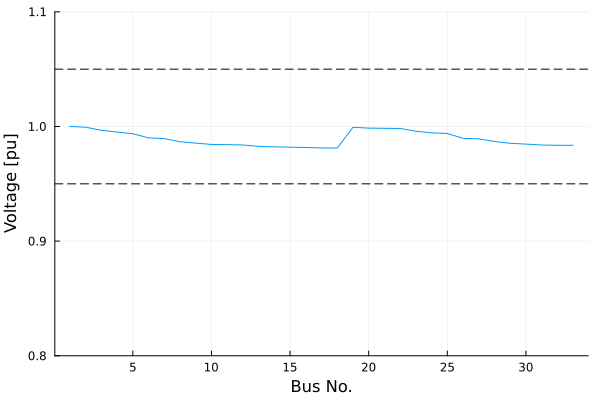

In [177]:
voltage=  XLSX.readdata("/Users/ebrah/Mehrnoush/veryhighvery0.xlsx", "veryhighvery0","A2:A34")
voltage = vec(voltage)
rpower=  XLSX.readdata("/Users/ebrah/Mehrnoush/veryhighvery0.xlsx", "veryhighvery0","B2:B34")
rpower = vec(rpower)
alphas=  XLSX.readdata("/Users/ebrah/Mehrnoush/veryhighvery0.xlsx", "veryhighvery0","C2:C34")
alphas = vec(alphas)
 pbb=  XLSX.readdata("/Users/ebrah/Mehrnoush/veryhighvery0.xlsx", "veryhighvery0","D2:D34")
 pbb= vec(pbb)

using Plots
plot(legend = false, ylims=(0.8, 1.1), xlabel="Bus No.", ylabel="Voltage [pu]")
plot!(1:33, voltage.^(1/2), label=false) 
hline!([1.05, 0.95], color=:black, linestyle=:dash, label=false)

# Display the plot
display(plot!())

Drawing the plot for voltage magnitude for OOS test

In [178]:
D = n_clusters
A = []
        for cluster in clusters
            cluster_size = length(cluster)
            delta_size = 3 * cluster_size
            aa = zeros(nbuses, delta_size)
            for n in 1:nbuses
                for j in 1:cluster_size 
                    first =  R[n,cluster[j]]*(1-alphas[cluster[j]])
                    second=  -R[n,cluster[j]]
                    third = -B[n,cluster[j]]
                    # Add elements to the corresponding positions in the matrix A
                    aa[n,(j-1)*3+1] = first
                    aa[n,(j-1)*3+2] = second
                    aa[n,(j-1)*3+3] = third
                end
            end
            push!(A, aa)
        end

In [179]:
voltagenew = []
for m in 1:n_samples
    for n in 1:n_buses
        pr = sum(dot(A[f][n,:], deltas_samples_oos[f][:,m]) for f in 1:D) -R[n,:]'*pbb +B[n,:]'*rpower +a[n] 
        voltagenew_value = pr 
        push!(voltagenew, voltagenew_value)
    end
end

In [180]:
voltagenew

3300-element Vector{Any}:
 1.0
 1.0000316963462677
 0.9997173535113457
 1.0007713618099716
 1.0020298984896736
 1.0019323180992388
 1.0005772183483939
 1.0044852990035527
 1.006127406382756
 1.0082981311636574
 1.0089110643067323
 1.008773303038524
 1.0074689261119385
 ⋮
 1.00266374009864
 0.9998946691995041
 0.9958262626148224
 0.9945665494588977
 1.0127566053270625
 1.0143446110176135
 1.015916189370506
 1.017498563278526
 1.0180270706993952
 1.0200108758428468
 1.0202959519654926
 1.0208681264328052

In [181]:
original_vector = rand(n_samples*nbuses)  
function split_vector(v, chunk_size)
    n = length(v)
    chunks = []
    for i in 1:chunk_size:n
        push!(chunks, v[i:min(i+chunk_size-1, n)].^(1/2))
    end
    return chunks
end

split_vectors = split_vector(voltagenew, 33)

100-element Vector{Any}:
 [1.0, 1.0000158480475536, 0.9998586667681316, 1.0003856065587766, 1.0010144347059504, 1.000965692768358, 1.0002885675385849, 1.002240140387299, 1.0030590243763107, 1.004140493737633  …  0.9964292759005992, 0.9957925030974121, 1.000927783061336, 1.0009330956045517, 0.9992940213135306, 0.9982547434901001, 0.9974811448049797, 0.9970757838279296, 0.9968649279964381, 0.9969688129419872]
 [1.0, 0.9999462324138368, 0.9991788175874667, 0.9997106786416193, 1.0004574315746515, 1.0008795203191803, 1.0003292523266636, 1.002409804887807, 1.0033055828732327, 1.0044630625809658  …  0.9943567102601518, 0.992799991016906, 1.001043183193457, 1.0013374996676725, 1.0017838163580939, 1.0022822337426651, 1.0022228686747043, 1.0027364817961344, 1.0027975135861207, 1.002996878096611]
 [1.0, 0.9997919194121122, 0.9985370384148081, 0.9984007515537359, 0.9983435174196785, 0.9971712160366389, 0.9963944605172831, 0.9970970045221257, 0.9975339608111021, 0.9981314897624245  …  0.99503108557

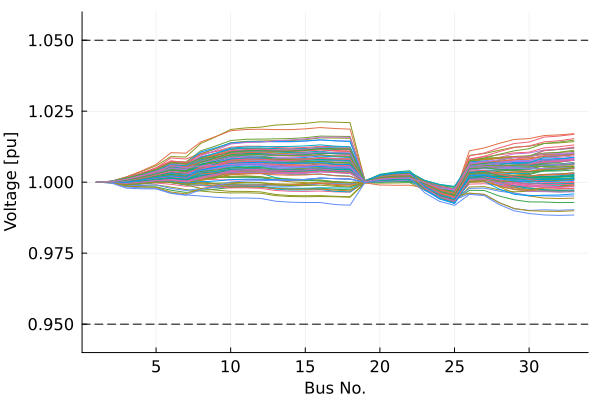

"/Users/ebrah/Mehrnoush/voltage_comparison1.pdf"

In [182]:
using Plots

plot(legend = false, ylims=(0.94, 1.06), xlabel="Bus No.", ylabel="Voltage [pu]",xguidefontsize=11,yguidefontsize=11)
for vector in split_vectors
    plot!(1:33, vector, label=false) 
end

hline!([1.05, 0.95], color=:black, linestyle=:dash, label=false)
xaxis!(tickfontsize=11)

display(plot!())
savefig(plot!(), "voltage_comparison1.pdf")

Objective function for OOS test

checking the imprical violation probabilty in voltage constraints (joint chance constraints)

In [ ]:
Vmax = 1.1
Vmin = 0.9

In [ ]:
b_first = zeros(nbuses,1)
for n in 1:nbuses
    b_first[n]= -R[n,:]'*pbb +B[n,:]'*rpower +a[n] - Vmax
end 
b_first
b_second = zeros(nbuses,1)
for n in 1:nbuses
    b_second[n] = R[n,:]'*pbb -B[n,:]'*rpower -a[n] + Vmin
end  
b_second
c_prime = zeros(2*nbuses+1,1)
for i in 1:2*nbuses+1
    if i <= nbuses
        c_prime[i] = b_first[i]  # The first 33 elements from b_first
    elseif i <= 2 * nbuses
        c_prime[i] = b_second[i - nbuses]  # The next 33 elements from b_second
    else
        0  # The 67th element is zero
    end
end 
c_prime

In [ ]:
generalobj1 = []
    # For each cluster, create samples for delta vector
    for cluster in clusters
        cluster_size = length(cluster)
        delta_size = 3 * cluster_size
        general = zeros(1,delta_size)
# Create samples
        for i in 1:1
            for j in 1:cluster_size
                p_av_min = 0
                p_l_min=  0
                q_l_min = 0

                # Add samples to the corresponding positions in the delta vector
                general[1,(j-1)*3+1] = p_av_min
                general[1,(j-1)*3+2] = p_l_min
                general[1,(j-1)*3+3] = q_l_min
            end
        end
        push!(generalobj1, general)
    end

In [ ]:
A = []
        for cluster in clusters
            cluster_size = length(cluster)
            delta_size = 3 * cluster_size
            aa = zeros(nbuses, delta_size)
            for n in 1:nbuses
                for j in 1:cluster_size 
                    first =  R[n,cluster[j]]*(1-alphas[cluster[j]])
                    second=  -R[n,cluster[j]]
                    third = -B[n,cluster[j]]
                    # Add elements to the corresponding positions in the matrix A
                    aa[n,(j-1)*3+1] = first
                    aa[n,(j-1)*3+2] = second
                    aa[n,(j-1)*3+3] = third
                end
            end
            push!(A, aa)
        end

In [ ]:
er=[]
for j in 1:n_clusters
        er1= length(clusters[j])
        push!(er,er1)
    end    
    maximum(er)

In [ ]:
AJ=vcat(A,-A,generalobj1)
 #a_prime= zeros(2*nbuses+1,n_clusters,3*maximum(er))
a_prime = Array{AffExpr}(undef, 2*nbuses+1, n_clusters, 3*maximum(er))
# for i in 1:(2*nbuses+1)
#     for j in 1:n_clusters
#         for k in 1:3*maximum(er)
#             a_prime[i, j, k] = @expression(model, 0)
#         end
#     end
# end
# #a_prime = Array{AffExpr}(undef, 2*nbuses+1, n_clusters, 3*maximum(er))
for b in 1:length(AJ)
    for c in 1:n_buses
        if b < n_clusters+1
            if 3*length(clusters[b]) == 3*maximum(er)
                for d in 1:3*maximum(er)
                    a_prime[c,b,d] = AJ[b][c,:][d]
                end   
            else
                for d in 1:3*maximum(er)
                    if d < 3*length(clusters[b])+1
                        a_prime[c,b,d] = AJ[b][c,:][d]
                    else
                        a_prime[c,b,d]=0
                    end    
                end    
            end
        elseif b > n_clusters && b < 2*n_clusters+1 
            if 3*length(clusters[b - n_clusters]) == 3*maximum(er)
                 for d in 1:3*maximum(er)
                     a_prime[c + nbuses,b - n_clusters,d] = AJ[b][c,:][d]
                 end   
            else
                for d in 1:3*maximum(er)
                    if d < 3*length(clusters[b - n_clusters])+1
                        a_prime[c + nbuses,b - n_clusters,d] = AJ[b][c,:][d]
                    else
                         a_prime[c + nbuses,b - n_clusters,d]=0
                    end    
                 end  
            end    
        else
            if c == 1
                if 3*length(clusters[b - 2*n_clusters]) == 3*maximum(er)
                    for d in 1:3*maximum(er) 
                        a_prime[c + 2*nbuses,b - 2*n_clusters,d] = AJ[b][c,:][d]
                    end    
                else
                     for d in 1:3*maximum(er)
                        if d < 3*length(clusters[b - 2*n_clusters])+1
                             a_prime[c + 2*nbuses,b - 2*n_clusters,d] =  AJ[b - 2*n_clusters][c,:][d]
                        else
                            a_prime[c + 2*nbuses,b - 2*n_clusters,d]=0
                        end    
                     end           
                 end
            end
         end
     end
end    
       
######################################################################

In [ ]:
maxvaluesofg=zeros(n_samples,1)
for i in 1:n_samples
    g33_first =zeros(nbuses,1)
    for n in 1:nbuses
        g33_first[n]= dot(AJ[1][n,:],deltas_samples_oos[1][:,i]) + dot(AJ[2][n,:],deltas_samples_oos[2][:,i]) + dot(AJ[3][n,:],deltas_samples_oos[3][:,i]) + dot(AJ[4][n,:],deltas_samples_oos[4][:,i]) + dot(AJ[5][n,:],deltas_samples_oos[5][:,i]) + b_first[n]
    end 
    g33_second = zeros( nbuses,1)
    for n in 1:nbuses
        g33_second[n]= dot(AJ[6][n,:],deltas_samples_oos[1][:,i]) + dot(AJ[7][n,:],deltas_samples_oos[2][:,i]) + dot(AJ[8][n,:],deltas_samples_oos[3][:,i]) + dot(AJ[9][n,:],deltas_samples_oos[4][:,i]) + dot(AJ[10][n,:],deltas_samples_oos[5][:,i]) + b_second[n]
    end  
    g_cc = vcat(g33_first, g33_second)
    maxvaluesofg[i] = maximum(g_cc[:,1])
end    

In [ ]:
maxvaluesofg

In [ ]:
maximum(maxvaluesofg[:,1])

In [ ]:

for element in maxvaluesofg[:,1]
    println(element)
end

Checking the inverter constraints (chance constraint) in OOS test

In [ ]:
constraint_refs = []
    for n in 1:nbuses
        if dfpv_pu[n, :S] != 0.0
            for cluster in clusters
                s_r= zeros(1,3*length(cluster))
                for j in 1:length(cluster)
                    if cluster[j] == n
                        indxofcluster = findfirst(x -> x == cluster, clusters)
                        s_r[1,(j-1)*3+1]=1
                        main_constraint_ref =S_per_time_pu[htime][:][n]^2 -  ((1-alphas[n])*dot(s_r,deltas_samples_oos[indxofcluster][:,1]))^2 - rpower[n]^2
                        push!(constraint_refs, main_constraint_ref)
                    end
                 end
             end 
        end   
     end

In [ ]:
constraint_refs

In [ ]:
constraint_refs = []
M = n_samples

for m in 1:M
    for n in 1:nbuses
        if dfpv_pu[n, :S] != 0.0
            for cluster in clusters
                s_r = zeros(1, 3 * length(cluster))
                for j in 1:length(cluster)
                    if cluster[j] == n
                        indxofcluster = findfirst(x -> x == cluster, clusters)
                        s_r[1, (j-1) * 3 + 1] = 1
                        main_constraint_ref = S_per_time_pu[htime][:][n]^2 - ((1 - alphas[n]) * dot(s_r, deltas_samples_oos[indxofcluster][:, m]))^2 - rpower[n]^2
                        push!(constraint_refs, main_constraint_ref)  # Save 'm' and 'n' alongside the constraint if needed
                    end
                end
            end
        end
    end
end

In [ ]:
minimum(constraint_refs)

In [ ]:
constraint_refs

In [ ]:
for value in constraint_refs
    println(value)
end

In [ ]:
num_negative_numbers = sum(x -> x < 0, constraint_refs)

In [ ]:
num_pvs=19

In [ ]:
# Assuming constraint_refs is your original 1300-element vector

# Define a function to round numbers based on the condition
function custom_round(x)
    if x > 0 && x < 10^-4
        return 0
    elseif x < 0 && x > -10^-4
        return 0
    else
        return x
    end
end

# Apply the rounding function to each element in constraint_refs
rounded_refs = [custom_round(x) for x in constraint_refs]

# Calculate the number of elements in each sub-vector
num_elements_per_vector = num_pvs

# Calculate the total number of sub-vectors needed
total_vectors = length(rounded_refs) ÷ num_elements_per_vector

# Create the sub-vectors from the rounded elements
sub_vectors = [rounded_refs[(i-1)*num_elements_per_vector+1 : i*num_elements_per_vector] for i in 1:total_vectors]

In [ ]:
# Assuming sub_vectors contains your 100 vectors
first_elements = [vec[1] for vec in sub_vectors]

In [ ]:
num_negative_numbers = sum(x -> x < 0, first_elements)

In [ ]:
# Assuming sub_vectors contains your 100 vectors

# Initialize an array to hold the vectors of n-th elements
elements_grouped_by_position = []

# Loop through the positions, 1 to 13 in each sub-vector
for i in 1:num_pvs
    push!(elements_grouped_by_position, [vec[i] for vec in sub_vectors])
end

# elements_grouped_by_position now contains 13 vectors, each vector contains all the n-th elements from the 100 vectors

In [ ]:
elements_grouped_by_position

In [ ]:
elements_grouped_by_position[9]

In [ ]:
# Count the number of negative values in each of the 13 vectors
num_negative_values = [count(x -> x < 0, vec) for vec in elements_grouped_by_position]

In [ ]:
tt=[]
for i in 1:100
    if -0.0001> elements_grouped_by_position[9][i]
        aa=elements_grouped_by_position[9][i]
            push!(tt,aa)
    end
end
tt

In [ ]:
elements_grouped_by_position[9][1]

# Drawing the plot for load and Pv simu

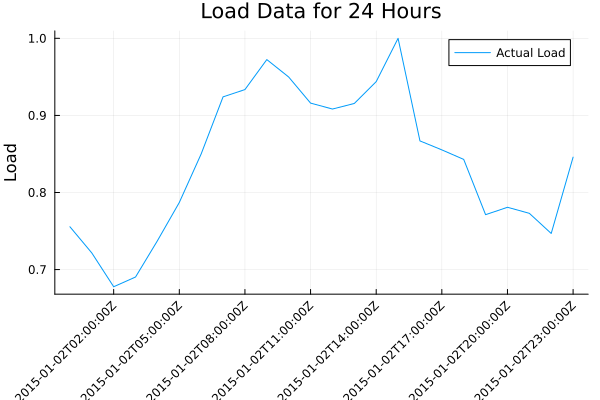

In [46]:

# Assuming you've read your dataset into a DataFrame called df
df = CSV.read("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/data/loaddata/time_series_60min_singleindex - Copy.csv", DataFrame)
# Define the normalization function
function normalize_column!(col::AbstractVector{T}) where T<:Real
    min_val = minimum(col)
    max_val = maximum(col)
    return (col) / (max_val)
end
# Apply the normalization to each numeric column
for col_name in names(df)
    if eltype(df[!, col_name]) <: Real
        df[!, col_name] = normalize_column!(df[!, col_name])
    end
end




# Define the format of your timestamps
dateformat = "yyyy-mm-dd\\THH:MM:SSZ"
# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("2015-01-02T00:00:00Z", dateformat)
end_time = DateTime("2015-01-03T00:00:00Z", dateformat)
df_24h_load = filter(row -> start_time <= DateTime(row[:utc_timestamp], dateformat) < end_time, df)
# Ensure that the column names are correct and that they are Symbols
# Plot the load data, using the correct column accessors
aanor = plot(df_24h_load.utc_timestamp, df_24h_load.AT_load_actual_entsoe_transparency, label="Actual Load", xlabel="Time", ylabel="Load", title="Load Data for 24 Hours", xrotation=45) # Rotates X-axis labels to make them readable
#savefig(aanor, "C:/Users/user/OneDrive - Rutgers University/Desktop/PHD- research/loadDataPlotnorm.png")




In [ ]:

data_url = "https://raw.githubusercontent.com/mieth-robert/testdata/main/single_household_smart_home.csv"
response = HTTP.get(data_url)
smart_home_data = CSV.File(IOBuffer(response.body)) |> DataFrame



smart_home_data[!, :local_15min] = DateTime.(smart_home_data[!, :local_15min], "m/d/y H:M")
# Load your smart_home_data DataFrame here
# smart_home_data = ...

# Define the format of your timestamps
dateformat = "m/d/y H:M"

# Ensure 'local_15min' is parsed to DateTime format if it's not already
#smart_home_data[!, :local_15min] = DateTime.(smart_home_data[!, :local_15min], dateformat)

# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("3/2/15 0:0", dateformat)
end_time = DateTime("3/3/15 0:0", dateformat)
df_24h = filter(row -> start_time <= row[:local_15min] < end_time, smart_home_data)

# Further filter to get only the start of each hour
df_hourly = df_24h[minute.(df_24h[!, :local_15min]) .== 0, :]

# Plot the solar data
plt = plot(df_hourly.local_15min, df_hourly.solar, label="Solar Energy", xlabel="Time", ylabel="Energy", title="Solar Energy Data for March 3, 2015", xrotation=45)






function normalize_column!(col::AbstractVector{T}) where T<:Real
    min_val = minimum(col)
    max_val = maximum(col)
    return (col) / (max_val)
end
# Apply the normalization to each numeric column
for col_name in names( df_hourly)
    if eltype( df_hourly[!, col_name]) <: Real
         df_hourly[!, col_name] = normalize_column!( df_hourly[!, col_name])
    end
end








# Define the format of your timestamps if your 'local_15min' column is in string format that needs parsing
dateformat = "m/d/y H:M"

# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("3/2/15 0:0", dateformat)
end_time = DateTime("3/3/15 0:0", dateformat)
df_24h = filter(row -> start_time <= row[:local_15min] < end_time, df_hourly)
# Ensure that the column names are correct and that they are Symbols
# Plot the solar data
banor = plot(df_24h.local_15min, df_24h.solar, label="Solar Energy", xlabel="Time", ylabel="Energy", title="Solar Energy Data for March 3, 2015", xrotation=45)


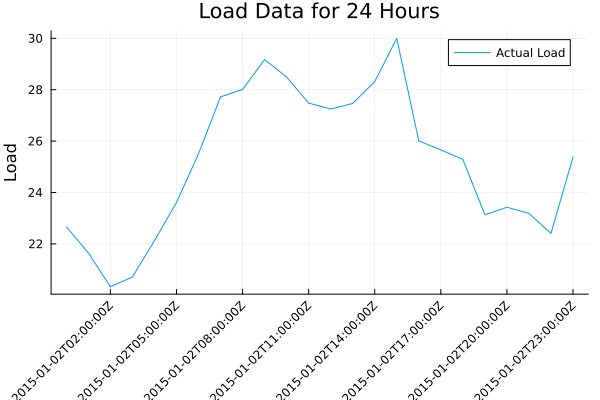

In [47]:

# Assuming you've read your dataset into a DataFrame called df
df = CSV.read("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/data/loaddata/time_series_60min_singleindex - Copy.csv", DataFrame)
# Define the normalization function
function normalize_column!(col::AbstractVector{T}) where T<:Real
    min_val = minimum(col)
    max_val = maximum(col)
    return (col) / (max_val)
end
# Apply the normalization to each numeric column
for col_name in names(df)
    if eltype(df[!, col_name]) <: Real
        df[!, col_name] = normalize_column!(df[!, col_name])
    end
end




# Define the format of your timestamps
dateformat = "yyyy-mm-dd\\THH:MM:SSZ"
# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("2015-01-02T00:00:00Z", dateformat)
end_time = DateTime("2015-01-03T00:00:00Z", dateformat)
df_24h = filter(row -> start_time <= DateTime(row[:utc_timestamp], dateformat) < end_time, df)
# Ensure that the column names are correct and that they are Symbols
# Plot the load data, using the correct column accessors
aanor = plot(df_24h.utc_timestamp, df_24h.AT_load_actual_entsoe_transparency, label="Actual Load", xlabel="Time", ylabel="Load", title="Load Data for 24 Hours", xrotation=45) # Rotates X-axis labels to make them readable
#savefig(aanor, "C:/Users/user/OneDrive - Rutgers University/Desktop/PHD- research/loadDataPlotnorm.png")





Vbase = 12.66 * 1e3;  # in Volts#basekV=12.66
Sbase = 1. * 1e6;  #in VA #baseMVA=1

cum24hourseachbus = []
for i in 1:33
    eachbus = df_24h.AT_load_actual_entsoe_transparency.* dfb[!,"Pd"][i].*0.5
    push!(cum24hourseachbus,eachbus)
end





# Define the format of your timestamps
dateformat = "yyyy-mm-dd\\THH:MM:SSZ"
# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("2015-01-02T00:00:00Z", dateformat)
end_time = DateTime("2015-01-03T00:00:00Z", dateformat)
df_24h = filter(row -> start_time <= DateTime(row[:utc_timestamp], dateformat) < end_time, df)
# Ensure that the column names are correct and that they are Symbols
# Plot the load data, using the correct column accessors
aanor = plot(df_24h.utc_timestamp, cum24hourseachbus[17], label="Actual Load", xlabel="Time", ylabel="Load", title="Load Data for 24 Hours", xrotation=45) # Rotates X-axis labels to make them readable
#savefig(aanor, "C:/Users/user/OneDrive - Rutgers University/Desktop/PHD- research/loadDataPlotnorm.png")




# cumbuseachhour = []
# for i in 1:24
#     eachhour = df_24h.AT_load_actual_entsoe_transparency[i].* dfb[!,"Pd"].* 1e3 ./ Sbase
#     push!(cumbuseachhour,eachhour)
# end    



# cumbuseachhourreactiveload = []
# for i in 1:24
#     eachhourreactiveload = df_24h.AT_load_actual_entsoe_transparency[i].* dfb[!,"Qd"].* 1e3 ./ Sbase
#     push!(cumbuseachhourreactiveload,eachhourreactiveload )
# end  


In [ ]:


data_url = "https://raw.githubusercontent.com/mieth-robert/testdata/main/single_household_smart_home.csv"
response = HTTP.get(data_url)
smart_home_data = CSV.File(IOBuffer(response.body)) |> DataFrame



smart_home_data[!, :local_15min] = DateTime.(smart_home_data[!, :local_15min], "m/d/y H:M")
# Load your smart_home_data DataFrame here
# smart_home_data = ...

# Define the format of your timestamps
dateformat = "m/d/y H:M"

# Ensure 'local_15min' is parsed to DateTime format if it's not already
#smart_home_data[!, :local_15min] = DateTime.(smart_home_data[!, :local_15min], dateformat)

# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("3/2/15 0:0", dateformat)
end_time = DateTime("3/3/15 0:0", dateformat)
df_24h = filter(row -> start_time <= row[:local_15min] < end_time, smart_home_data)

# Further filter to get only the start of each hour
df_hourly = df_24h[minute.(df_24h[!, :local_15min]) .== 0, :]

# Plot the solar data
plt = plot(df_hourly.local_15min, df_hourly.solar, label="Solar Energy", xlabel="Time", ylabel="Energy", title="Solar Energy Data for March 3, 2015", xrotation=45)






function normalize_column!(col::AbstractVector{T}) where T<:Real
    min_val = minimum(col)
    max_val = maximum(col)
    return (col) / (max_val)
end
# Apply the normalization to each numeric column
for col_name in names( df_hourly)
    if eltype( df_hourly[!, col_name]) <: Real
         df_hourly[!, col_name] = normalize_column!( df_hourly[!, col_name])
    end
end








# Define the format of your timestamps if your 'local_15min' column is in string format that needs parsing
dateformat = "m/d/y H:M"

# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("3/2/15 0:0", dateformat)
end_time = DateTime("3/3/15 0:0", dateformat)
df_24h = filter(row -> start_time <= row[:local_15min] < end_time, df_hourly)
# Ensure that the column names are correct and that they are Symbols
# Plot the solar data
aanor = plot(df_24h.local_15min, df_24h.solar, label="Solar Energy", xlabel="Time", ylabel="Energy", title="Solar Energy Data for March 3, 2015", xrotation=45)











Vbase = 12.66 * 1e3;  # in Volts#basekV=12.66
Sbase = 1. * 1e6;  #in VA #baseMVA=1
df_24h.solar[21] = 0.0005
cum24hourseachbuspv = []
for i in 1:33
    eachbuspv = df_24h.solar.* dfpv[!, :S][i].*2# here we multiply each curve (24 hours) by a single value corres
    push!(cum24hourseachbuspv,eachbuspv)
end

aanor = plot(df_24h.local_15min, cum24hourseachbuspv[17], label="Solar Energy", xlabel="Time", ylabel="Energy", title="Solar Energy Data for March 3, 2015", xrotation=45)


# cumbuseachhourpv = []
# for i in 1:24
#     eachhourpv = df_24h.solar[i].* dfpv[!, :S] # here we scale the system capacity for all 33 buses at one specific hour by multiplying the sysytem capacity for all 33 buse by the amount of genereated pv (curve) at one specific time. then we repeat ut 24 hours for all hours. so we have 24 33dimension vectors.
#     push!(cumbuseachhourpv,eachhourpv)
# end    
# cumbuseachhourpv[10][:]




# pvcum = []
# for h in 1:24
#     Random.seed!(123)
#     pav = rand(length(cumbuseachhourpv[h][:])) .* cumbuseachhourpv[h][:] # Generate random scaling factors between 0 and 1 and then Scale the values between 0 and 100% of system capacity in each hour , it means that we have generated pv a 33 colum vector data for each hour in 24 hours
#     pavs = pav .* 1e3 ./ Sbase 
#     push!(pvcum,pavs)
# end  
# pvcum



In [ ]:
cum24hourseachbus[17]

In [ ]:
 cum24hourseachbuspv[17]

In [ ]:
using Plots

# Sample data for illustration
vector1 = rand(24)  # Random data simulating "Load Data"
vector2 = rand(24)  # Random data simulating "Total Available PV at bus 17"

# Time labels from 12 AM to 11 PM
hours = ["12 AM", "1 AM", "2 AM", "3 AM", "4 AM", "5 AM", "6 AM", "7 AM", "8 AM", "9 AM", "10 AM", "11 AM", 
         "12 PM", "1 PM", "2 PM", "3 PM", "4 PM", "5 PM", "6 PM", "7 PM", "8 PM", "9 PM", "10 PM", "11 PM"]

# Create the plot with specific settings for colors and labels
comparison= plot(1:24, [cum24hourseachbus[17],cum24hourseachbuspv[17]], label=["LOAD Data at Bus 17" "Total Available PV at Bus 17"], color=[:blue :red],
     xticks=(1:24, hours), xlabel="Time of Day", ylabel="kW",linewidth=2.5  legend=:topleft, xrotation=45)

# savefig(comparison, "C:/Users/user/OneDrive - Rutgers University/Desktop/PHD- research/loadDataPlotnorm.png")

In [ ]:
pvcum1 = pvcum./ 1e3 .* Sbase 

In [ ]:
totalpvofallnodesineachtime=[]
for j in 1:24
    time = sum(pvcum1[j][i] for i in 1:33)
    push!(totalpvofallnodesineachtime,time)
end  
totalpvofallnodesineachtime

In [ ]:
totalloadofallnodesineachtime=[]
for i in 1:24
    time = sum(cum24hourseachbus[j][i]  for j in 1:33)
    push!(totalloadofallnodesineachtime,time)
end
totalloadofallnodesineachtime

In [ ]:
using Plots
#at each hour we sum all pav of all 33 nodes 
# Sample data for illustration
vector1 = rand(24)  # Random data simulating "Load Data"
vector2 = rand(24)  # Random data simulating "Total Available PV at bus 17"

# Time labels from 12 AM to 11 PM
hours = ["12 AM", "1 AM", "2 AM", "3 AM", "4 AM", "5 AM", "6 AM", "7 AM", "8 AM", "9 AM", "10 AM", "11 AM", 
         "12 PM", "1 PM", "2 PM", "3 PM", "4 PM", "5 PM", "6 PM", "7 PM", "8 PM", "9 PM", "10 PM", "11 PM"]

# Create the plot with specific settings for colors and labels
comparison= plot(1:24, [totalloadofallnodesineachtime,totalpvofallnodesineachtime], label=["LOAD Data" "Total Available PV"], color=[:blue :red],
     xticks=(1:24, hours), xlabel="Time of Day", ylabel="kW",linewidth=2.5,  legend=:topleft, xrotation=45)
savefig(comparison, "/Users/ebrah/Mehrnoush/loadDataPlotnorm.pdf")

In [ ]:
totalpvofallnodesineachtime